**Author :** Rutendo F. Sigauke

**Input  :** 

1. Gene counts (counts_filt_5ptrunc_gene_stranded_counts.txt)

2. Normalized intergenic counts (genes_inter_bidir_filtered.tsv.gz)

3. Summary of normalized counts (gene_bidir_tpm_summary_allBidirs_filteredSamples.tsv.gz)

4. Significant pairs
    
        - True pairs
        
        - Swapped bidirectional pairs (from this notebook)
        

**Output :**

1. Swapped bidirectional normalized counts file (genes_inter_sampled_bidir_by_chr.tsv.gz)

2. Figures (summary of relative FP)

# Introduction

Here genes are correlated with bidirectional transcripts from other chromosomes to asses the false positive rate. The hypothesis is that we would find more pairs from within chromosome comparison compared to outside chromosome comparison. The main caveat being we also expect a small fraction of true pairs from outside chromosome comparisons. In other words, we can not distinguish indirect interactions due to TF binding across chromosomes.

# Libraries

In [1]:
library(data.table) ## load files into R faster
library(ggplot2) ## plotting package
library(cowplot) ## plots + arrange plots etc
library(dplyr) ## data wrangling


Attaching package: ‘dplyr’


The following objects are masked from ‘package:data.table’:

    between, first, last


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




# Functions

## Swap bidirectionals with other chromosomes

In [2]:
swapped_chr_bidirs <- function(tpmDT, chrA, genenames, seed=42){
    
    set.seed(seed)
    
    #1. assign trascript type
    tpmDT$transcipt_type <- ifelse(tpmDT$gene_transcript %in% genenames,
                                                 "Gene","Bidirectional")
    
    #2. get chrA genes and bidirectionals
    tpmDT_chrA_genes <- subset(tpmDT, chrom == chrA & transcipt_type =='Gene')
    tpmDT_chrA_bidirs <- subset(tpmDT, chrom == chrA & transcipt_type !='Gene')
    
    #3. get non-chrA bidirectionals
    tpmDT_other_chr_bidirs <- subset(tpmDT, chrom != chrA & transcipt_type !='Gene')

    #4. sample non-chrA bidirectionals
    sample_other_chr_bidirs <- tpmDT_other_chr_bidirs[sample(1:nrow(tpmDT_other_chr_bidirs),
                                                             nrow(tpmDT_chrA_bidirs),
                                                            replace = FALSE),]
    #5. merge the annotations with sampled bidirectionals
    tpmDT_chrA_bidirs_new <- cbind(tpmDT_chrA_bidirs[,1:6], 
                                   sample_other_chr_bidirs[,7:ncol(sample_other_chr_bidirs)])
    
    #6. combine the gene and bidirectional counts
    tpmDT_chrA_genes_other_chr_bidirs <- rbind(tpmDT_chrA_genes,
                                               tpmDT_chrA_bidirs_new)
    
    #7. remove transcipt columns
    tpmDT_chrA_genes_sampled_bidirs <- tpmDT_chrA_genes_other_chr_bidirs[,transcipt_type:=NULL]
    
    print(paste0("Seed   : ", seed))
    print(paste("Genes in: ", 
          as.character(chrA)," = ", 
          as.character(nrow(tpmDT_chrA_genes))))
    
    print(paste("Bidirs in: ", 
          as.character(chrA)," = ", 
          as.character(nrow(tpmDT_chrA_bidirs_new))))
    
    print(paste("Total Transcripts: ",
                " = ", 
                as.character(nrow(tpmDT_chrA_genes_sampled_bidirs))))
    
    return(tpmDT_chrA_genes_sampled_bidirs)
}

## Filter pairs for downstream of PAS

In [3]:
removing_DoPAD_bidirs <- function(pairs, dist_DoPAD=15000, number_observed=10, percent_transcribed=60) {
    #' Remove pairs where the bidirectionals transcript is 
    #' downstream of Polyadenylation Site (DoPAD)
    
    #1. Subset by distance from TES
    pairs_dopad <- subset(pairs, 
                          abs(distance_tes) < dist_DoPAD &
                          percent_transcribed_both>percent_transcribed)
    
    #2. Label bidirectionals that fall closer to the TES than to the TSS
    pairs_dopad$filter <- ifelse(abs(pairs_dopad$distance_tss) < abs(pairs_dopad$distance_tes),
                                        FALSE, TRUE)
    
    pairs_dopad_removing <- pairs_dopad[pairs_dopad$filter=='TRUE',]

    #This removes any pairs with bidirectionals in DoPAD as opposed to only removing the pair
    pairs_keeping <- pairs[!pairs$transcript_2 %in% pairs_dopad_removing$transcript_2,]
    
    pairs_keeping_nObs <- subset(pairs_keeping, nObs > number_observed)
    return(pairs_keeping_nObs)
    
}

## Assess false positive rates

In [4]:
count_num_genes <- function(chr_sig_original, chr_sig_swapped){
    
    #' get number of bidirectionals assigned to a genes
    
    #1. Get unique pairs across tissues
    chr_sig_uniq_original <- unique(chr_sig_original[, c('transcript1_chrom',
                                                         'transcript_1',
                                                         'transcript_2')])
    
    
    chr_sig_uniq_swapped <- unique(chr_sig_swapped[, c('transcript1_chrom',
                                                       'transcript_1',
                                                       'transcript_2')])
    
    #2. Count the number of bidirectionals assigned to a gene
    num_bidirs_per_gene_original <- as.data.frame(table(as.character(chr_sig_uniq_original$transcript_1)))
    num_bidirs_per_gene_swapped <- as.data.frame(table(as.character(chr_sig_uniq_swapped$transcript_1)))
    print(paste0("Number of genes (Original) = ", nrow(num_bidirs_per_gene_original)))
    print(paste0("Number of genes (Swapped) = ", nrow(num_bidirs_per_gene_swapped)))
    
    #3. Merge the bidirectional assigned tables
    num_bidirs_per_gene_merged <-merge(num_bidirs_per_gene_original, 
                                       num_bidirs_per_gene_swapped, 
                                       by='Var1')
    colnames(num_bidirs_per_gene_merged) <- c('gene',
                                              'og_bidirs',
                                              'swapped_bidirs')
    print(paste0("Shared genes = ", nrow(num_bidirs_per_gene_merged)))    
    return(num_bidirs_per_gene_merged)
}

## Filter pairs

In [5]:
removing_DoPAD_bidirs <- function(pairs, dist_DoPAD=15000, number_observed=10, percent_transcribed=1) {
    #' Remove pairs where the bidirectionals transcript is Downstream of Polyadenylation Site (DoPAD)
    #1. Subset by distance from TES
    pairs_dopad <- subset(pairs, 
                          abs(distance_tes) < dist_DoPAD &
                         percent_transcribed_both>percent_transcribed)
    
    #2. Label bidirectionals that fall closer to the TES than to the TSS
    pairs_dopad$filter <- ifelse(abs(pairs_dopad$distance_tss) < abs(pairs_dopad$distance_tes),
                                        FALSE, TRUE)
    
    pairs_dopad_removing <- pairs_dopad[pairs_dopad$filter=='TRUE',]

    #This removes any pairs with bidirectionals in DoPAD as opposed to only removing the pair
    pairs_keeping <- pairs[!pairs$transcript_2 %in% pairs_dopad_removing$transcript_2,]
    
    pairs_keeping_nObs <- subset(pairs_keeping, nObs > number_observed)
    return(pairs_keeping_nObs)
}

## Get random pairs

In [6]:
shuffle_genes <- function(pairs_DT, seed=1235){
    ##shuffle genes within a chromosome pairs
    
    #set the seed
    set.seed(seed)
    pairs_DT_shuffled_genes <- pairs_DT
    pairs_DT_shuffled_genes$transcript_1 <- sample(pairs_DT$transcript_1, 
                                                     nrow(pairs_DT)) 
    return(pairs_DT_shuffled_genes)
   
}

## Get overlaps with true pairs

In [7]:
map_overlaps <- function(overlap_DT, nascent_pairs) {
    
    #assign bidirectional id
    overlap_DT$bidirid <- paste0(overlap_DT$V6,':',
                                 overlap_DT$V7,'-',
                                 overlap_DT$V8)
    
    #get columns with gene and bidirectional ids and relabel the gene ids
    nascent_pairs_gene <- nascent_pairs[,c('transcript_1','transcript_2')]
    nascent_pairs_gene$gene_id <- as.character(lapply(strsplit(nascent_pairs_gene$transcript_1, ':'),
                                                      `[`, 1))
    
    #merge the overlap data table with significant pairs
    overlap_DT_updated <- merge(overlap_DT, 
                                nascent_pairs_gene,
                                by.x='bidirid', by.y='transcript_2')
    
    #return overlaps where the genes also overlaps
    overlap_DT_overlaps <- unique(overlap_DT_updated[overlap_DT_updated$V4 == overlap_DT_updated$gene_id,])
    
    return(overlap_DT_overlaps)
    
}

# Load data

## Gene counts

In [8]:
counts_genes <- data.table::fread('/Users/rusi2317/projects/meta_analysis_qc/hg38/processed_data/counts/genes/counts_filt_5ptrunc_gene_stranded_counts.txt',
                                 sep='\t')
dim(counts_genes)
head(counts_genes, 3)

[1] 28889  1651

chrom start stop  gene_transcript       score strand SRR7266931 SRR7266932
1 chr1  12623 14409 DDX11L1:NR_046018.2   .     +       0         0         
2 chr1  14361 28620 WASH7P:NR_024540.1    .     -      43         4         
3 chr1  17368 17436 MIR6859-1:NR_106918.1 .     -       0         0         
  SRR7266933 SRR7266934 ⋯ SRR3713716 SRR3713717 SRR3713718 SRR3713719
1  0          0         ⋯  0          0          0          0        
2 45         34         ⋯ 12         10         38         30        
3  0          0         ⋯  0          0          0          0        
  SRR8483105 SRR8483106 SRR8483107 SRR8483108 SRR8483109 SRR8483110
1  0          0          0          0          0          0        
2 42         62         53         44         49         61        
3  0          0          0          0          0          0

## Bidirectionals and Genes TPMs

In [9]:
genes_inter_bidir_filtered <- data.table::fread("/Users/rusi2317/projects/meta_analysis_qc/hg38/processed_data/counts/normalized/genes_inter_bidir_filtered.tsv.gz")
nrow(genes_inter_bidir_filtered)
head(genes_inter_bidir_filtered, 3)

[1] 350859

chrom start    stop     gene_transcript      score strand SRR7266931
1 chr19 58351969 58355183 A1BG-AS1:NR_015380.2 .     +      0.4715395 
2 chr19 58345182 58353492 A1BG:NM_130786.4     .     -      0.6391889 
3 chr10 50799408 50885627 A1CF:NM_014576.4     .     -      0.0000000 
  SRR7266932  SRR7266933  SRR7266934  ⋯ SRR3713715   SRR3713716  SRR3713717  
1 0.275847512 0.350156404 0.289034470 ⋯ 4.7901330211 8.908832855 9.3601802570
2 0.413680061 0.742015737 0.722426895 ⋯ 1.7346237696 1.293155683 1.3308983947
3 0.001591118 0.002164006 0.002778636 ⋯ 0.0004371834 0.001835253 0.0008409737
  SRR3713718   SRR8483105 SRR8483106 SRR8483107 SRR8483108 SRR8483109  
1 1.126521e+01 24.003756  23.515781  22.649555  21.094696  23.696213379
2 1.224210e+00  2.425766   1.773117   2.165353   2.375756   2.301772168
3 9.417236e-04  0.000000   0.000000   0.000000   0.000000   0.002545294
  SRR8483110  
1 22.427576708
2  2.450560985
3  0.001178184

## Bidirectional and Gene transcript summary 

In [10]:
gene_bidir_tpm_summary_allBidirs_filteredSamples <- data.table::fread('/Users/rusi2317/projects/meta_analysis_qc/hg38/processed_data/counts/normalized/gene_bidir_tpm_summary_allBidirs_filteredSamples.tsv.gz')
head(gene_bidir_tpm_summary_allBidirs_filteredSamples, 3)

chrom start stop  gene_transcript       score strand length stdev     
1 chr1  12623 14409 DDX11L1:NR_046018.2   .     +       1787  0.07209929
2 chr1  14361 28620 WASH7P:NR_024540.1    .     -      14260  0.19045740
3 chr1  17368 17436 MIR6859-1:NR_106918.1 .     -         69  0.00000000
  variance    sum        mean        median    coefvar   max      min
1 0.005198307   6.760542 0.009002053 0.0000000 8.0092052 1.252323 0  
2 0.036274023 163.616971 0.217865474 0.1674576 0.8741973 1.587046 0  
3 0.000000000   0.000000 0.000000000 0.0000000        NA 0.000000 0  
  num_transcribed percent_transcribed transcript_type
1  29              3.861518           genes          
2 749             99.733688           genes          
3   0              0.000000           genes

# Perform the sampling

## All chromosomes bidirectionals swapped with other chromosome bidirs

In [11]:
chroms <- c(paste0('chr',seq(1:22)), 'chrX','chrY')
chroms

[1] "chr1"  "chr2"  "chr3"  "chr4"  "chr5"  "chr6"  "chr7"  "chr8"  "chr9" 
[10] "chr10" "chr11" "chr12" "chr13" "chr14" "chr15" "chr16" "chr17" "chr18"
[19] "chr19" "chr20" "chr21" "chr22" "chrX"  "chrY"

In [12]:
##create a list for the data.tables
swap_list_inter <- list()

##populate the list by chromosome
for (i in 1:length(chroms)){
    
    print(chroms[i])
    
    ##swap the bidirectionals by other chromosome bidirectionals
    swap_list_inter[[i]] <- swapped_chr_bidirs(genes_inter_bidir_filtered,
                                              chroms[i], 
                                               counts_genes$gene_transcript)
    
}

[1] "chr1"
[1] "Seed   : 42"
[1] "Genes in:  chr1  =  2467"
[1] "Bidirs in:  chr1  =  28554"
[1] "Total Transcripts:   =  31021"
[1] "chr2"
[1] "Seed   : 42"
[1] "Genes in:  chr2  =  1621"
[1] "Bidirs in:  chr2  =  27364"
[1] "Total Transcripts:   =  28985"
[1] "chr3"
[1] "Seed   : 42"
[1] "Genes in:  chr3  =  1379"
[1] "Bidirs in:  chr3  =  19700"
[1] "Total Transcripts:   =  21079"
[1] "chr4"
[1] "Seed   : 42"
[1] "Genes in:  chr4  =  892"
[1] "Bidirs in:  chr4  =  18315"
[1] "Total Transcripts:   =  19207"
[1] "chr5"
[1] "Seed   : 42"
[1] "Genes in:  chr5  =  1127"
[1] "Bidirs in:  chr5  =  20035"
[1] "Total Transcripts:   =  21162"
[1] "chr6"
[1] "Seed   : 42"
[1] "Genes in:  chr6  =  1297"
[1] "Bidirs in:  chr6  =  20285"
[1] "Total Transcripts:   =  21582"
[1] "chr7"
[1] "Seed   : 42"
[1] "Genes in:  chr7  =  1186"
[1] "Bidirs in:  chr7  =  16885"
[1] "Total Transcripts:   =  18071"
[1] "chr8"
[1] "Seed   : 42"
[1] "Genes in:  chr8  =  885"
[1] "Bidirs in:  chr8  =  16354"
[1] "T

In [13]:
##How many chromosomes are there
length(swap_list_inter)

[1] 24

In [14]:
swap_inter_DT <- do.call(rbind, swap_list_inter)
nrow(swap_inter_DT)
head(swap_inter_DT, 3)

[1] 350859

chrom start     stop      gene_transcript        score strand SRR7266931 
1 chr1   33306765  33321098 A3GALT2:NM_001080438.1 .     -      0.360282930
2 chr1   93992833  94121148 ABCA4:NM_000350.3      .     -      0.007673022
3 chr1  229516581 229558707 ABCB10:NM_012089.3     .     -      3.081201404
  SRR7266932 SRR7266933 SRR7266934 ⋯ SRR3713715  SRR3713716  SRR3713717 
1 0.34038251 0.40393668 0.40648132 ⋯ 0.327338210 1.023864318 1.211724567
2 0.01066059 0.00579959 0.00651596 ⋯ 0.006737058 0.009017293 0.009578778
3 3.60219771 3.25718270 3.12955064 ⋯ 0.699874416 0.940161322 0.993649305
  SRR3713718  SRR8483105 SRR8483106 SRR8483107 SRR8483108 SRR8483109 SRR8483110
1 1.179132423 0.2959358  0.2627096  0.5213759  0.4593501  0.360335   0.3854807 
2 0.001261921 0.1112804  0.1587765  0.2574075  0.2712524  0.138987   0.1468267 
3 1.542593034 2.1768845  1.7086253  1.5538392  1.7433840  1.790234   1.7936406

In [15]:
data.table::fwrite(swap_inter_DT,
           '/Users/rusi2317/projects/meta_analysis_qc/hg38/processed_data/counts/sample_chr_bidirectionals/genes_inter_sampled_bidir_by_chr.tsv.gz',
           sep='\t')

## Run correlations between sampled bidirectionals

A script that generates correlation analysis for all chromosomes was used to create sbatch scripts. 

- Below is an example script from chromosome 21 genes. Each chromosome had a separate script.

```sh
#!/bin/bash                              
#SBATCH --job-name=sampled_corMatR_chromosomes_inter_chr21
                      
#SBATCH --mail-type=FAIL,END
#SBATCH --mail-user=rutendo.sigauke@cuanschutz.edu 

#SBATCH --nodes=1
#SBATCH --ntasks=1 # Num of CPU

#SBATCH --time=24:00:00 # Time limit
#SBATCH --partition=short

#SBATCH --mem=250gb 

#SBATCH --output=/scratch/Users/rusi2317/e_and_o/%x_%j.out              
#SBATCH --error=/scratch/Users/rusi2317/e_and_o/%x_%j.err 

echo 'BEGIN: Correlations...................'

cat /scratch/Users/rusi2317/projects/meta_analysis_qc/hg38/annotations/hg38.chrom.sizes.tsv | grep -w chr21 > /scratch/Users/rusi2317/projects/meta_analysis_qc/hg38/annotations/hg38.chrom.sizes_chr21.tsv

#run script       

Rscript --vanilla /scratch/Users/rusi2317/projects/meta_analysis_qc/hg38/bin/bidir_gene_pairs/R/bidir_gene_correlations_tissues.R -t /scratch/Users/rusi2317/projects/meta_analysis_qc/hg38/processed_data/counts/sample_chr_bidirectionals/genes_inter_sampled_bidir_by_chr.tsv.gz -m /scratch/Users/rusi2317/projects/meta_analysis_qc/hg38/bin/bidir_gene_pairs/test/230131_db_output.tsv -c /scratch/Users/rusi2317/projects/meta_analysis_qc/hg38/annotations/hg38.chrom.sizes_chr21.tsv -o /scratch/Users/rusi2317/projects/meta_analysis_qc/hg38/processed_data/sampled_bidir_correlations/inter/

echo 'DONE: Matrix pearson correlation......'

```

# Compare pairs from sampled vs. original chromosomes 

## Load significant pairs

In [16]:
sig_pairs_path <- '/Users/rusi2317/projects/meta_analysis_qc/hg38/processed_data/correlations/inter/significant'

##get paths for the tables
sig_pairs_path_files <- list.files(path=sig_pairs_path, 
                              pattern="*gz", 
                                   full.names=TRUE)

##load correlations
sig_pairs_path_DT_list <- lapply(sig_pairs_path_files, 
                                   data.table::fread) 


In [17]:
sig_pairs_sampled_path <- '/Users/rusi2317/projects/meta_analysis_qc/hg38/processed_data/sampled_bidir_correlations/inter/significant'

##get paths for the tables
sig_pairs_sampled_path_files <- list.files(path=sig_pairs_sampled_path, 
                                           pattern="*gz",
                                           full.names=TRUE)

##load correlations
sig_pairs_sampled_path_DT_list <- lapply(sig_pairs_sampled_path_files, 
                                   data.table::fread) 


In [18]:
##combine to one data.table
sig_pairs_path_DT <- do.call(rbind, sig_pairs_path_DT_list)

##filter pairs for DoPAD
sig_pairs_path_DT_filt <- removing_DoPAD_bidirs(sig_pairs_path_DT)

##add gene ids 
sig_pairs_path_DT_filt$gene_id <- as.character(lapply(strsplit(sig_pairs_path_DT_filt$transcript_1, ':'),
                                                      `[`, 1))
head(sig_pairs_path_DT_filt, 3)

transcript1_chrom transcript1_start transcript1_stop transcript_1          
1 chr1              33306765          33321098         A3GALT2:NM_001080438.1
2 chr1              33306765          33321098         A3GALT2:NM_001080438.1
3 chr1              33306765          33321098         A3GALT2:NM_001080438.1
  transcript1_score transcript1_strand transcript2_chrom transcript2_start
1 .                 -                  chr1              33036652         
2 .                 -                  chr1              33224694         
3 .                 -                  chr1              33242850         
  transcript2_stop transcript_2           ⋯ pval         adj_p_BH     nObs
1 33037238         chr1:33036652-33037238 ⋯ 1.238535e-25 9.631487e-23 215 
2 33224966         chr1:33224694-33224966 ⋯ 1.846433e-04 2.198101e-03  16 
3 33243170         chr1:33242850-33243170 ⋯ 1.706406e-04 2.060092e-03  22 
  t         distance_tss distance_tes position   tissue
1 11.984604 284153       269820       downstream blood 
2  5.028114  96268        81935       downstream blood 
3  4.606764  78088        63755       downstream blood 
  percent_transcribed_both gene_id
1 96.846847                A3GALT2
2  7.207207                A3GALT2
3  9.909910                A3GALT2

## Get bidir counts

In [19]:
##create a list for the data.tables
num_bidirs_per_gene_list <- list()

##populate the list by chromosome
for (i in 1:length(chroms)){
    
    print(paste0("Assessing .................. ",chroms[i]))
    
    ##remove downstream of PAS
    sig_pairs_sampled_path_DT <- removing_DoPAD_bidirs(sig_pairs_sampled_path_DT_list[[i]],
                                                             number_observed=10, 
                                                             percent_transcribed=0)
    
    sig_pairs_path_DT <- removing_DoPAD_bidirs(sig_pairs_path_DT_list[[i]],
                                                     number_observed=10,
                                                     percent_transcribed=0)
    
    ##get chromosome bidirectionals counts summaries
    num_bidirs_per_gene_list[[i]] <- count_num_genes(sig_pairs_path_DT, 
                                                      sig_pairs_sampled_path_DT) 
    
    ##get difference
    num_bidirs_per_gene_list[[i]]$difference <- num_bidirs_per_gene_list[[i]]$og_bidirs - num_bidirs_per_gene_list[[i]]$swapped_bidirs
    
    ##merge gene summaries with metadata
    num_bidirs_per_gene_list[[i]] <- merge(num_bidirs_per_gene_list[[i]], 
                                           gene_bidir_tpm_summary_allBidirs_filteredSamples,
                                           by.x='gene',
                                           by.y='gene_transcript')
    
}


[1] "Assessing .................. chr1"
[1] "Number of genes (Original) = 2425"
[1] "Number of genes (Swapped) = 2429"
[1] "Shared genes = 2413"
[1] "Assessing .................. chr2"
[1] "Number of genes (Original) = 939"
[1] "Number of genes (Swapped) = 938"
[1] "Shared genes = 932"
[1] "Assessing .................. chr3"
[1] "Number of genes (Original) = 1359"
[1] "Number of genes (Swapped) = 1359"
[1] "Shared genes = 1345"
[1] "Assessing .................. chr4"
[1] "Number of genes (Original) = 1217"
[1] "Number of genes (Swapped) = 1215"
[1] "Shared genes = 1209"
[1] "Assessing .................. chr5"
[1] "Number of genes (Original) = 487"
[1] "Number of genes (Swapped) = 489"
[1] "Shared genes = 484"
[1] "Assessing .................. chr6"
[1] "Number of genes (Original) = 811"
[1] "Number of genes (Swapped) = 820"
[1] "Shared genes = 802"
[1] "Assessing .................. chr7"
[1] "Number of genes (Original) = 786"
[1] "Number of genes (Swapped) = 786"
[1] "Shared genes = 78

In [20]:
head(num_bidirs_per_gene_list[[1]], 3)

gene                   og_bidirs swapped_bidirs difference chrom start    
1 A3GALT2:NM_001080438.1 46        44               2        chr1   33306765
2 ABCA4:NM_000350.3      60        48              12        chr1   93992833
3 ABCB10:NM_012089.3     42        64             -22        chr1  229516581
  stop      score strand length ⋯ variance   sum        mean      median    
1  33320348 .     -       13584 ⋯ 1.88009093  630.26975 0.8392407 0.38548067
2  94120398 .     -      127566 ⋯ 0.03336814   89.75271 0.1195109 0.04870435
3 229557957 .     -       41377 ⋯ 2.80433356 1357.48398 1.8075686 1.34971018
  coefvar   max       min        num_transcribed percent_transcribed
1 1.6338151 13.093527 0.00000000 749              99.73369          
2 1.5284752  1.723609 0.00000000 749              99.73369          
3 0.9264459 16.317967 0.03787755 751             100.00000          
  transcript_type
1 genes          
2 genes          
3 genes

## Generate plots 

### Number of bidirections `same` vs. `sampled` chromosome bidirectionals

In [21]:
num_bidirs_per_gene <- do.call(rbind, num_bidirs_per_gene_list)
nrow(num_bidirs_per_gene)
head(num_bidirs_per_gene, 3)


[1] 23751

gene                   og_bidirs swapped_bidirs difference chrom start    
1 A3GALT2:NM_001080438.1 46        44               2        chr1   33306765
2 ABCA4:NM_000350.3      60        48              12        chr1   93992833
3 ABCB10:NM_012089.3     42        64             -22        chr1  229516581
  stop      score strand length ⋯ variance   sum        mean      median    
1  33320348 .     -       13584 ⋯ 1.88009093  630.26975 0.8392407 0.38548067
2  94120398 .     -      127566 ⋯ 0.03336814   89.75271 0.1195109 0.04870435
3 229557957 .     -       41377 ⋯ 2.80433356 1357.48398 1.8075686 1.34971018
  coefvar   max       min        num_transcribed percent_transcribed
1 1.6338151 13.093527 0.00000000 749              99.73369          
2 1.5284752  1.723609 0.00000000 749              99.73369          
3 0.9264459 16.317967 0.03787755 751             100.00000          
  transcript_type
1 genes          
2 genes          
3 genes

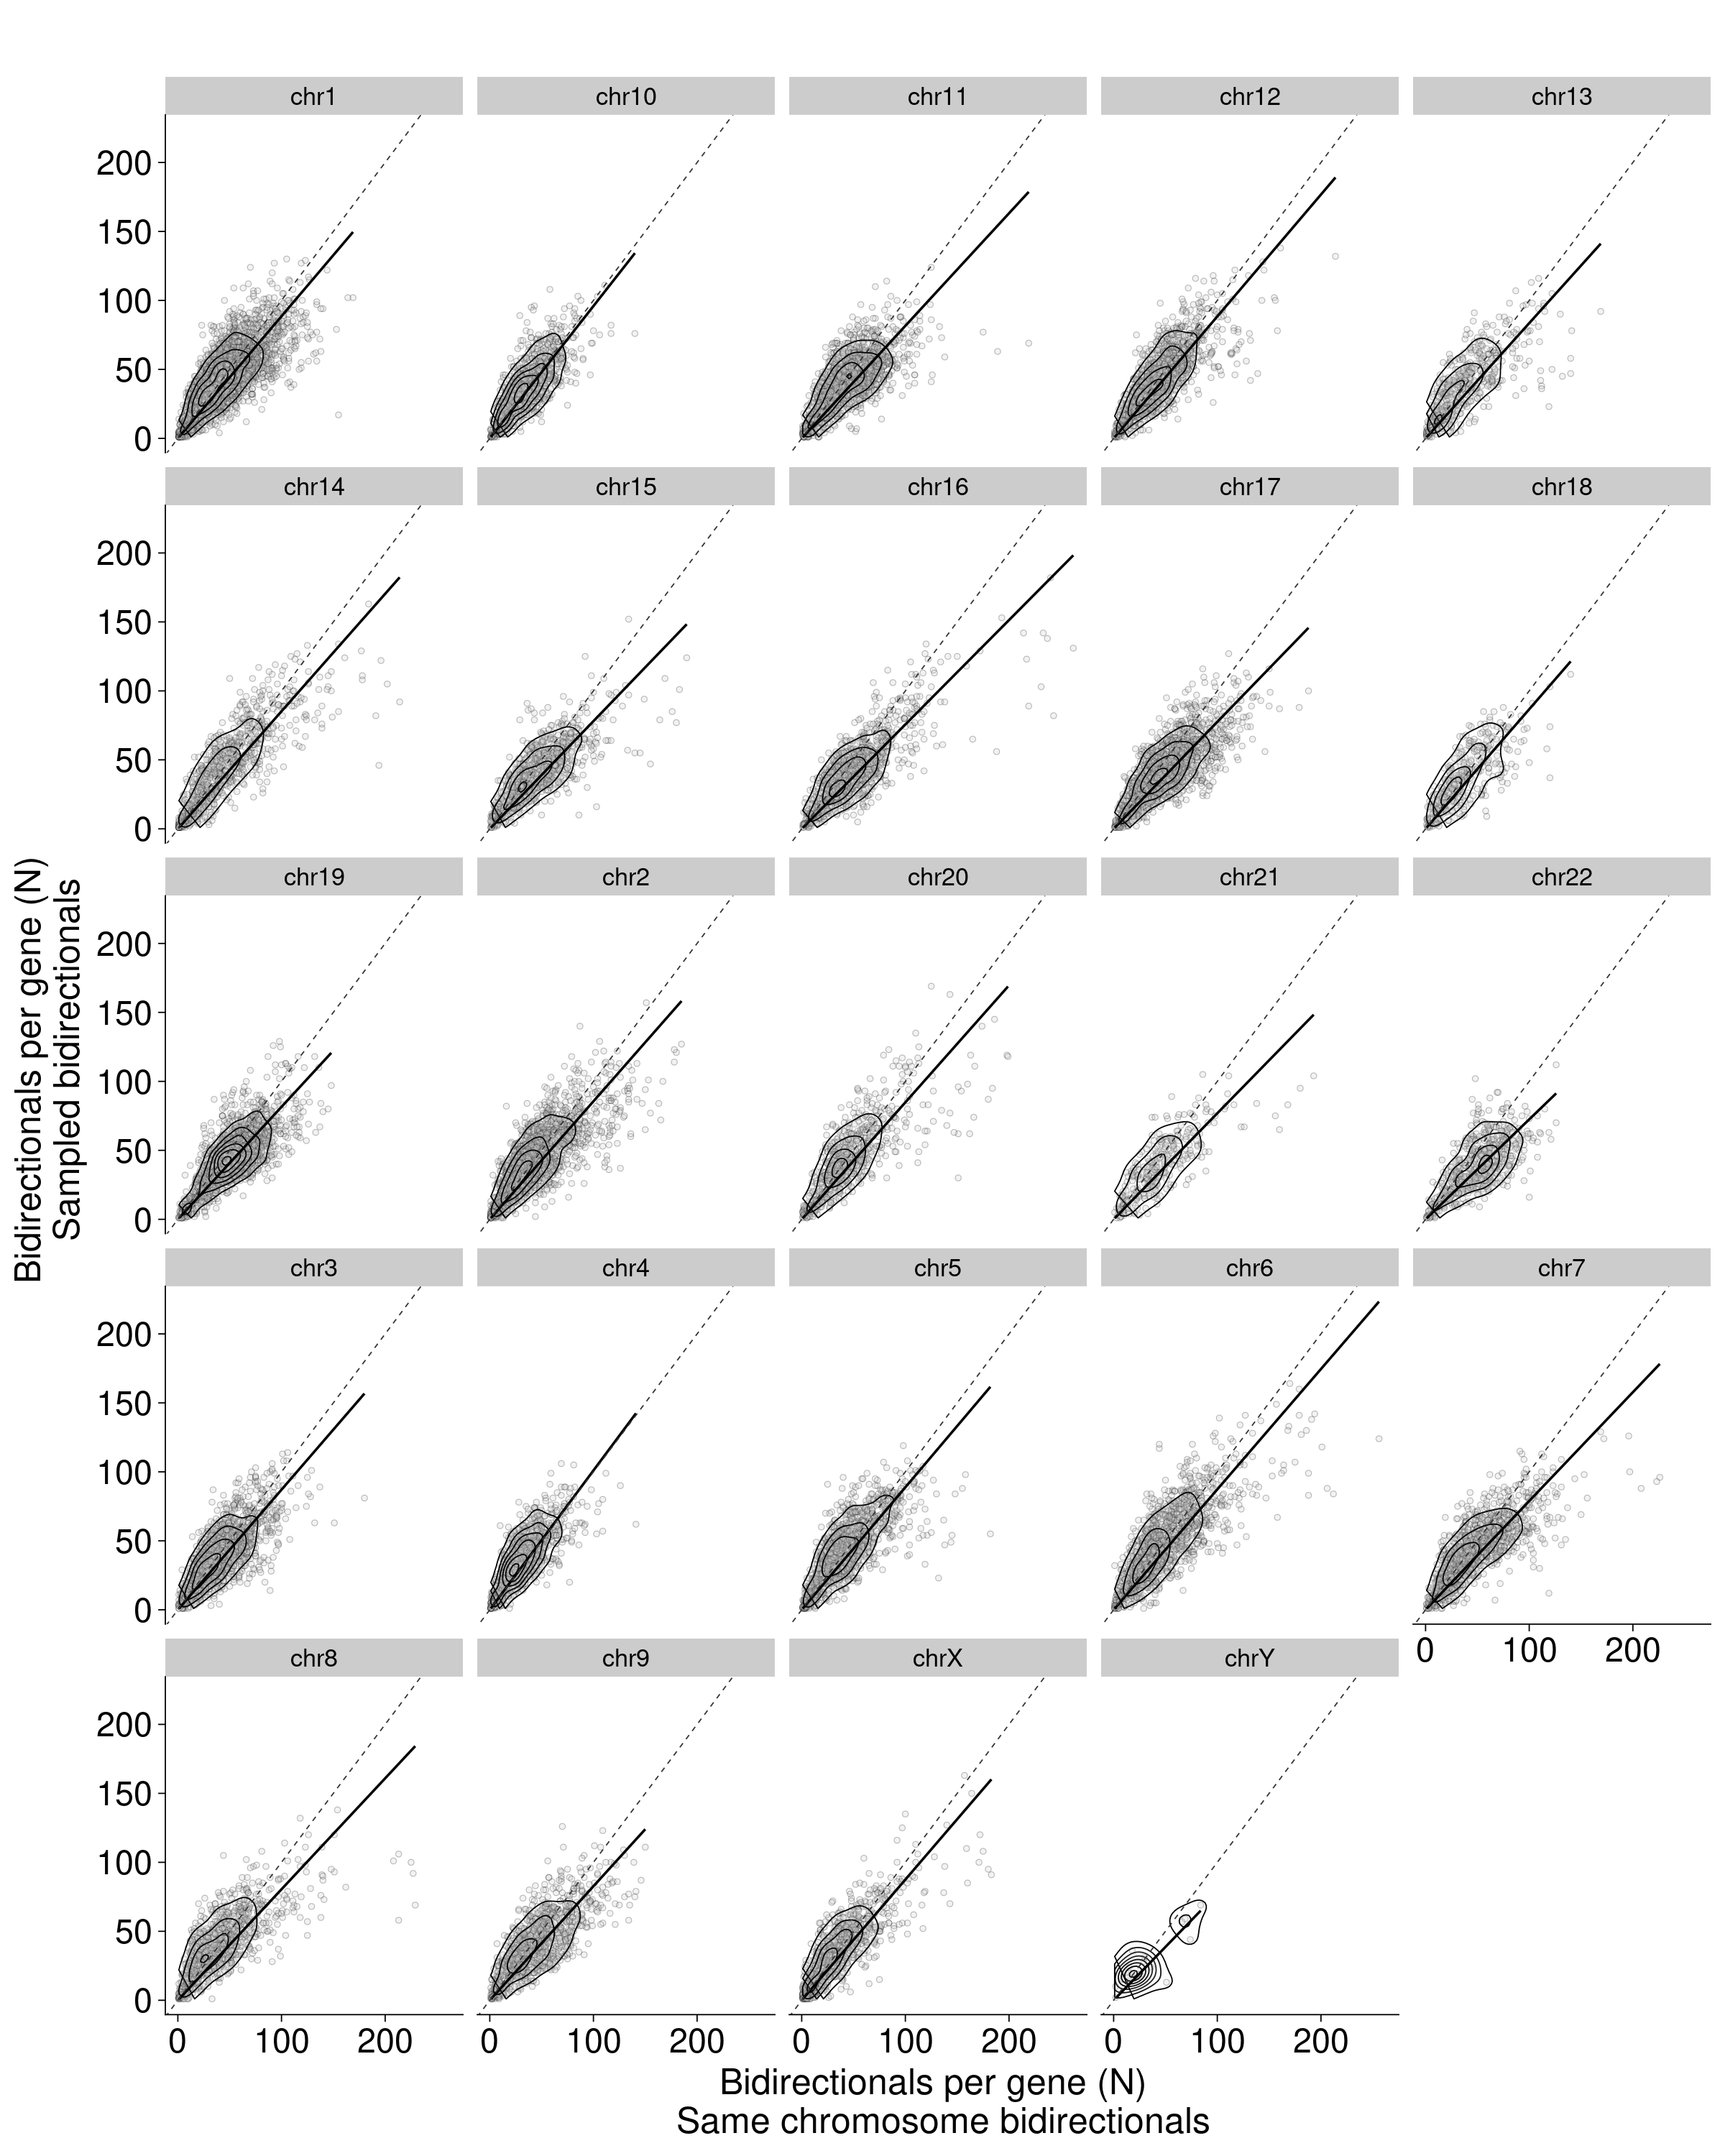

In [22]:
options(repr.plot.width=20, repr.plot.height=25)

num_bidirs <- ggplot(num_bidirs_per_gene,
                     aes(x=og_bidirs,
                         y=swapped_bidirs)) +
geom_point(shape = 21, size=2, fill='gray80', alpha=0.25) + 
stat_density_2d(aes(fill = ..level..), 
                alpha=0.075,
                geom = "polygon", 
                colour="black", 
                fill='gray90') +
geom_smooth(method = "lm", se = FALSE, color = 'black', formula=y~x+0) +
geom_abline(intercept = 0, slope=1, linetype='dashed', color = 'gray20') +
facet_wrap(vars(chrom)) +
theme_cowplot(24) + 
ggtitle(" ") +
xlab("Bidirectionals per gene (N) \n Same chromosome bidirectionals") +
ylab("Bidirectionals per gene (N) \n Sampled bidirectionals") +
labs(fill=" ") +
theme(plot.title = element_text(hjust = 0.5),
      title = element_text(size = 36), 
      axis.title = element_text(size = 30), 
      axis.text = element_text(size = 28)) 

num_bidirs

### Difference in assignments

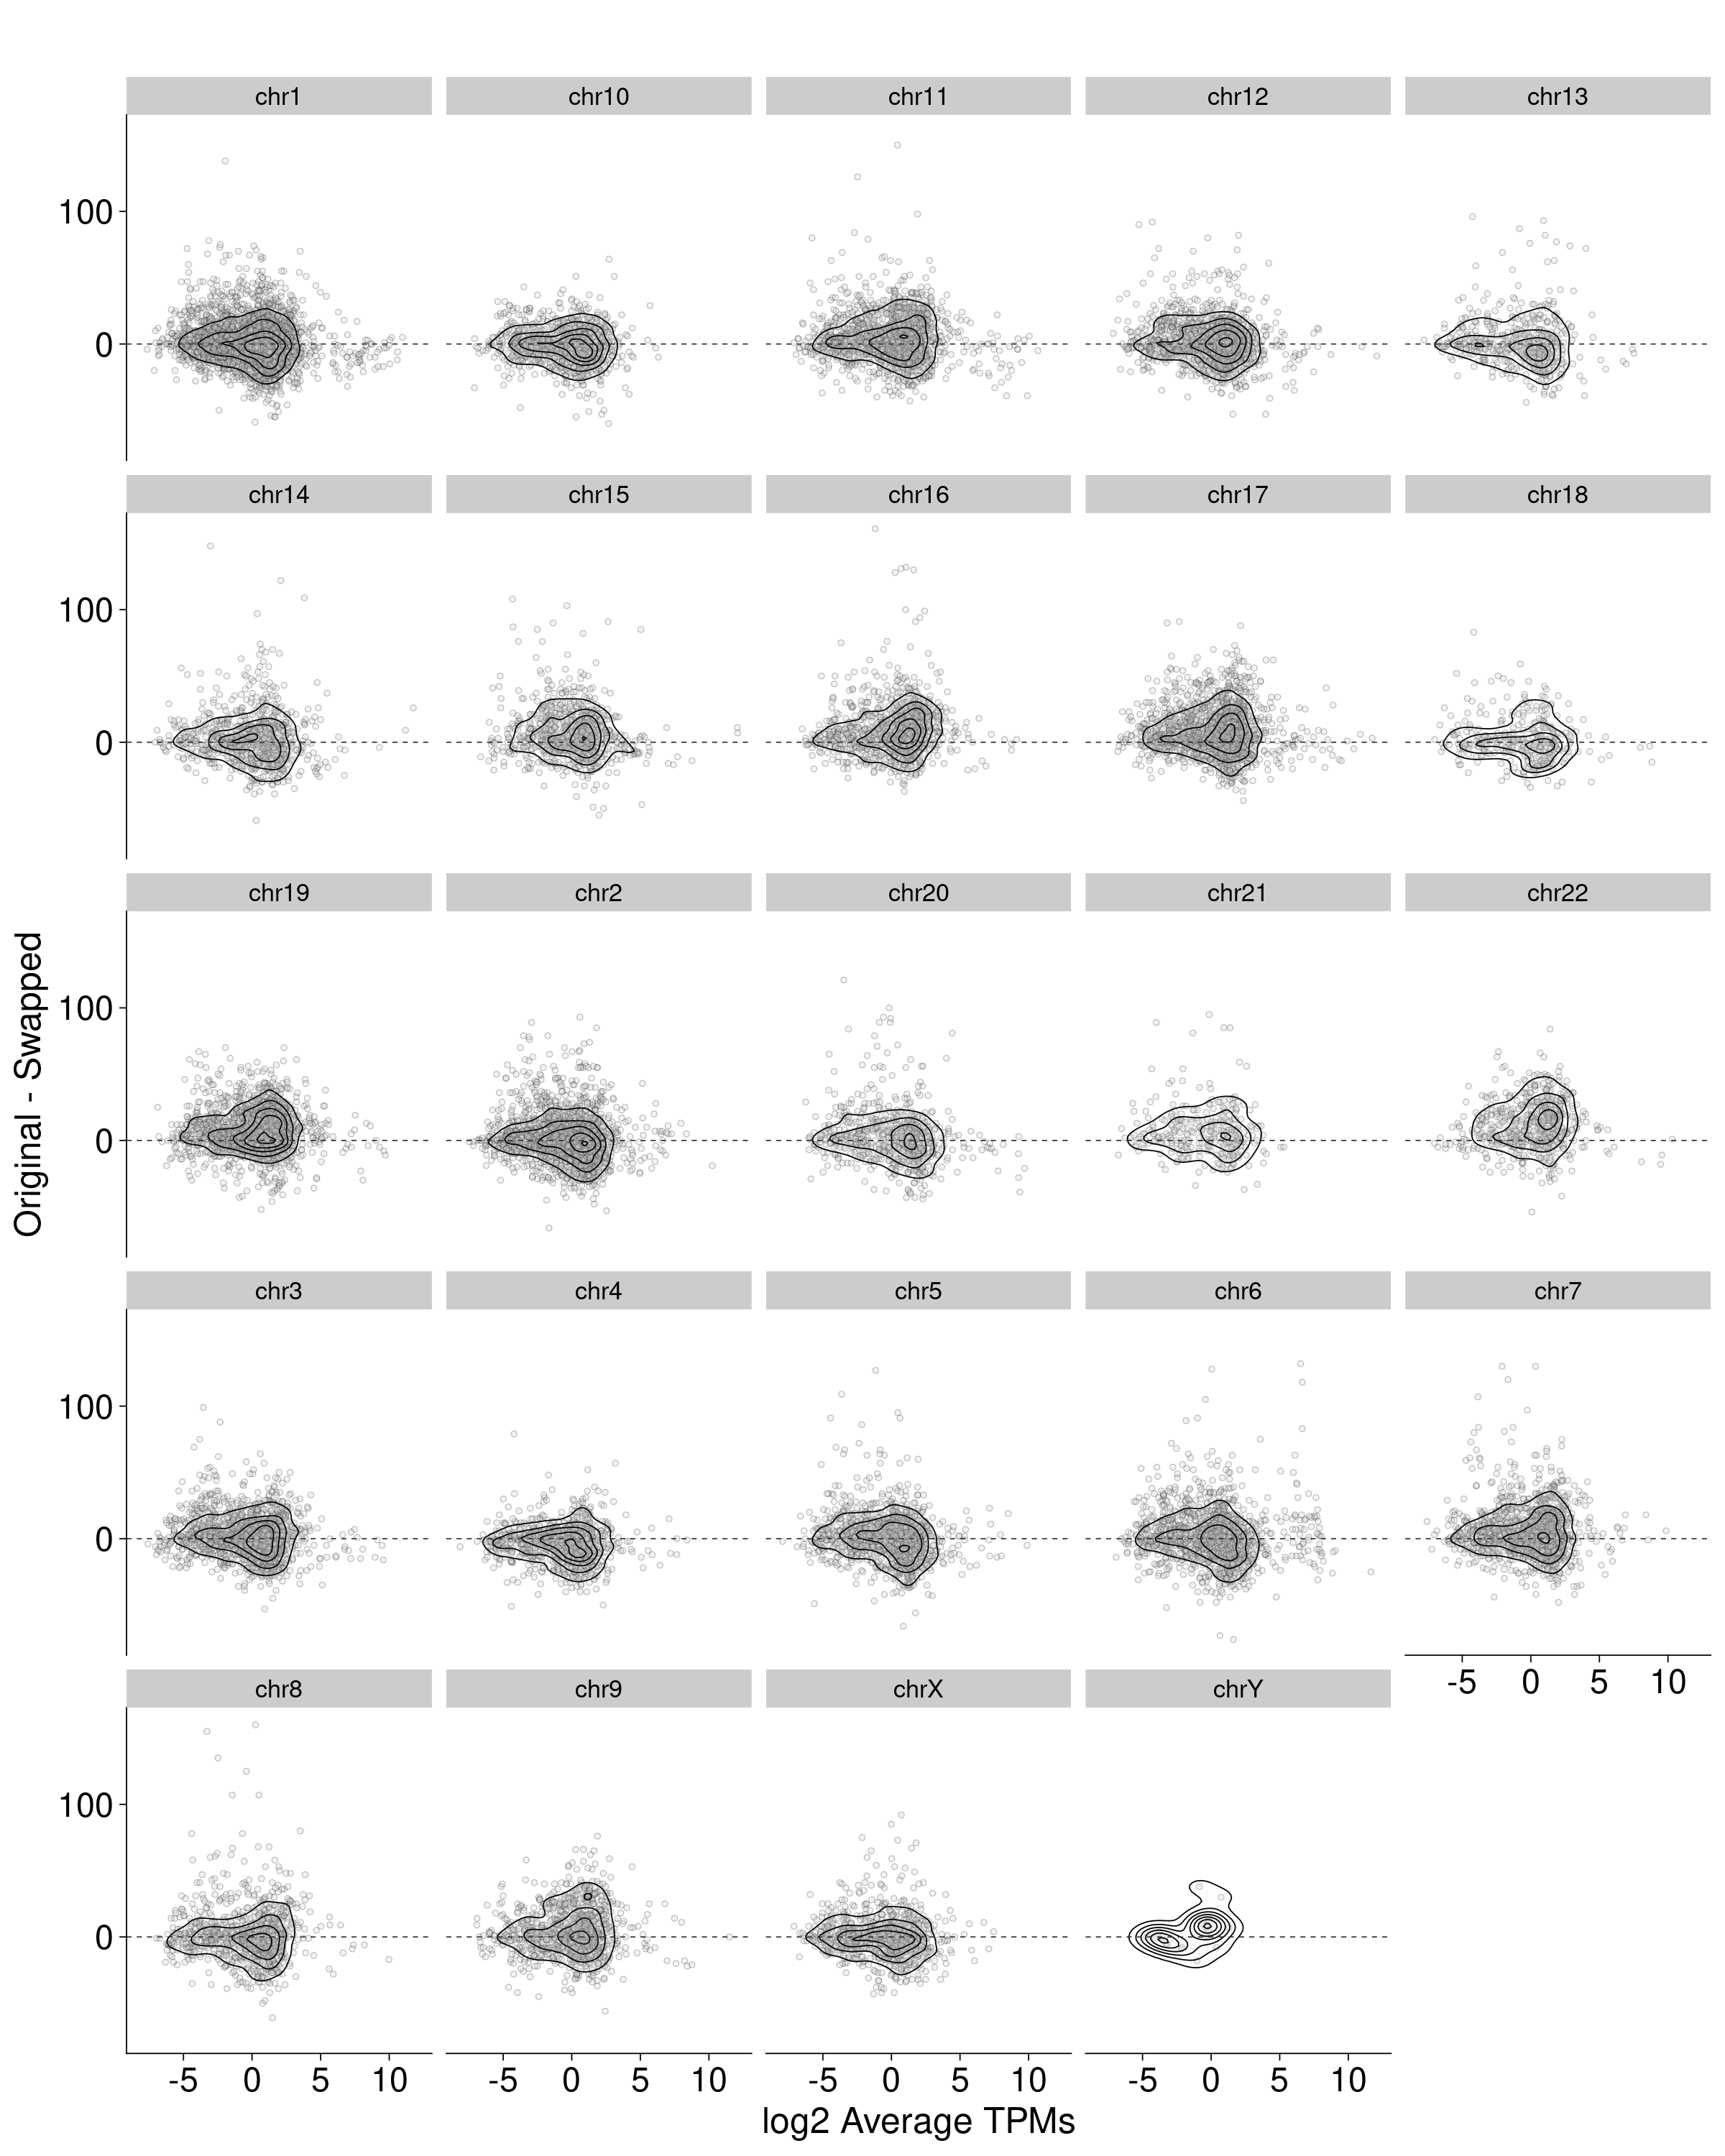

In [23]:
options(repr.plot.width=20, repr.plot.height=25)

diff_num_bidirs_tpms <- ggplot(num_bidirs_per_gene,
                     aes(x=log(mean, 2),
                         y=difference)) +
geom_point(shape = 21, size=2, fill='gray80', alpha=0.25) + 
stat_density_2d(aes(fill = ..level..), 
                alpha=0.075,
                geom = "polygon", 
                colour="black", 
                fill='gray90') +
geom_hline(yintercept=0, linetype="dashed", color = "gray20") +
facet_wrap(vars(chrom)) +
theme_cowplot(24) + 
ggtitle(" ") +
xlab("log2 Average TPMs") +
ylab("Original - Swapped") +
labs(fill=" ") +
theme(plot.title = element_text(hjust = 0.5),
      title = element_text(size = 36), 
      axis.title = element_text(size = 30), 
      axis.text = element_text(size = 28)) 

diff_num_bidirs_tpms

### Coefficient of variation

#### Compared to TPMs

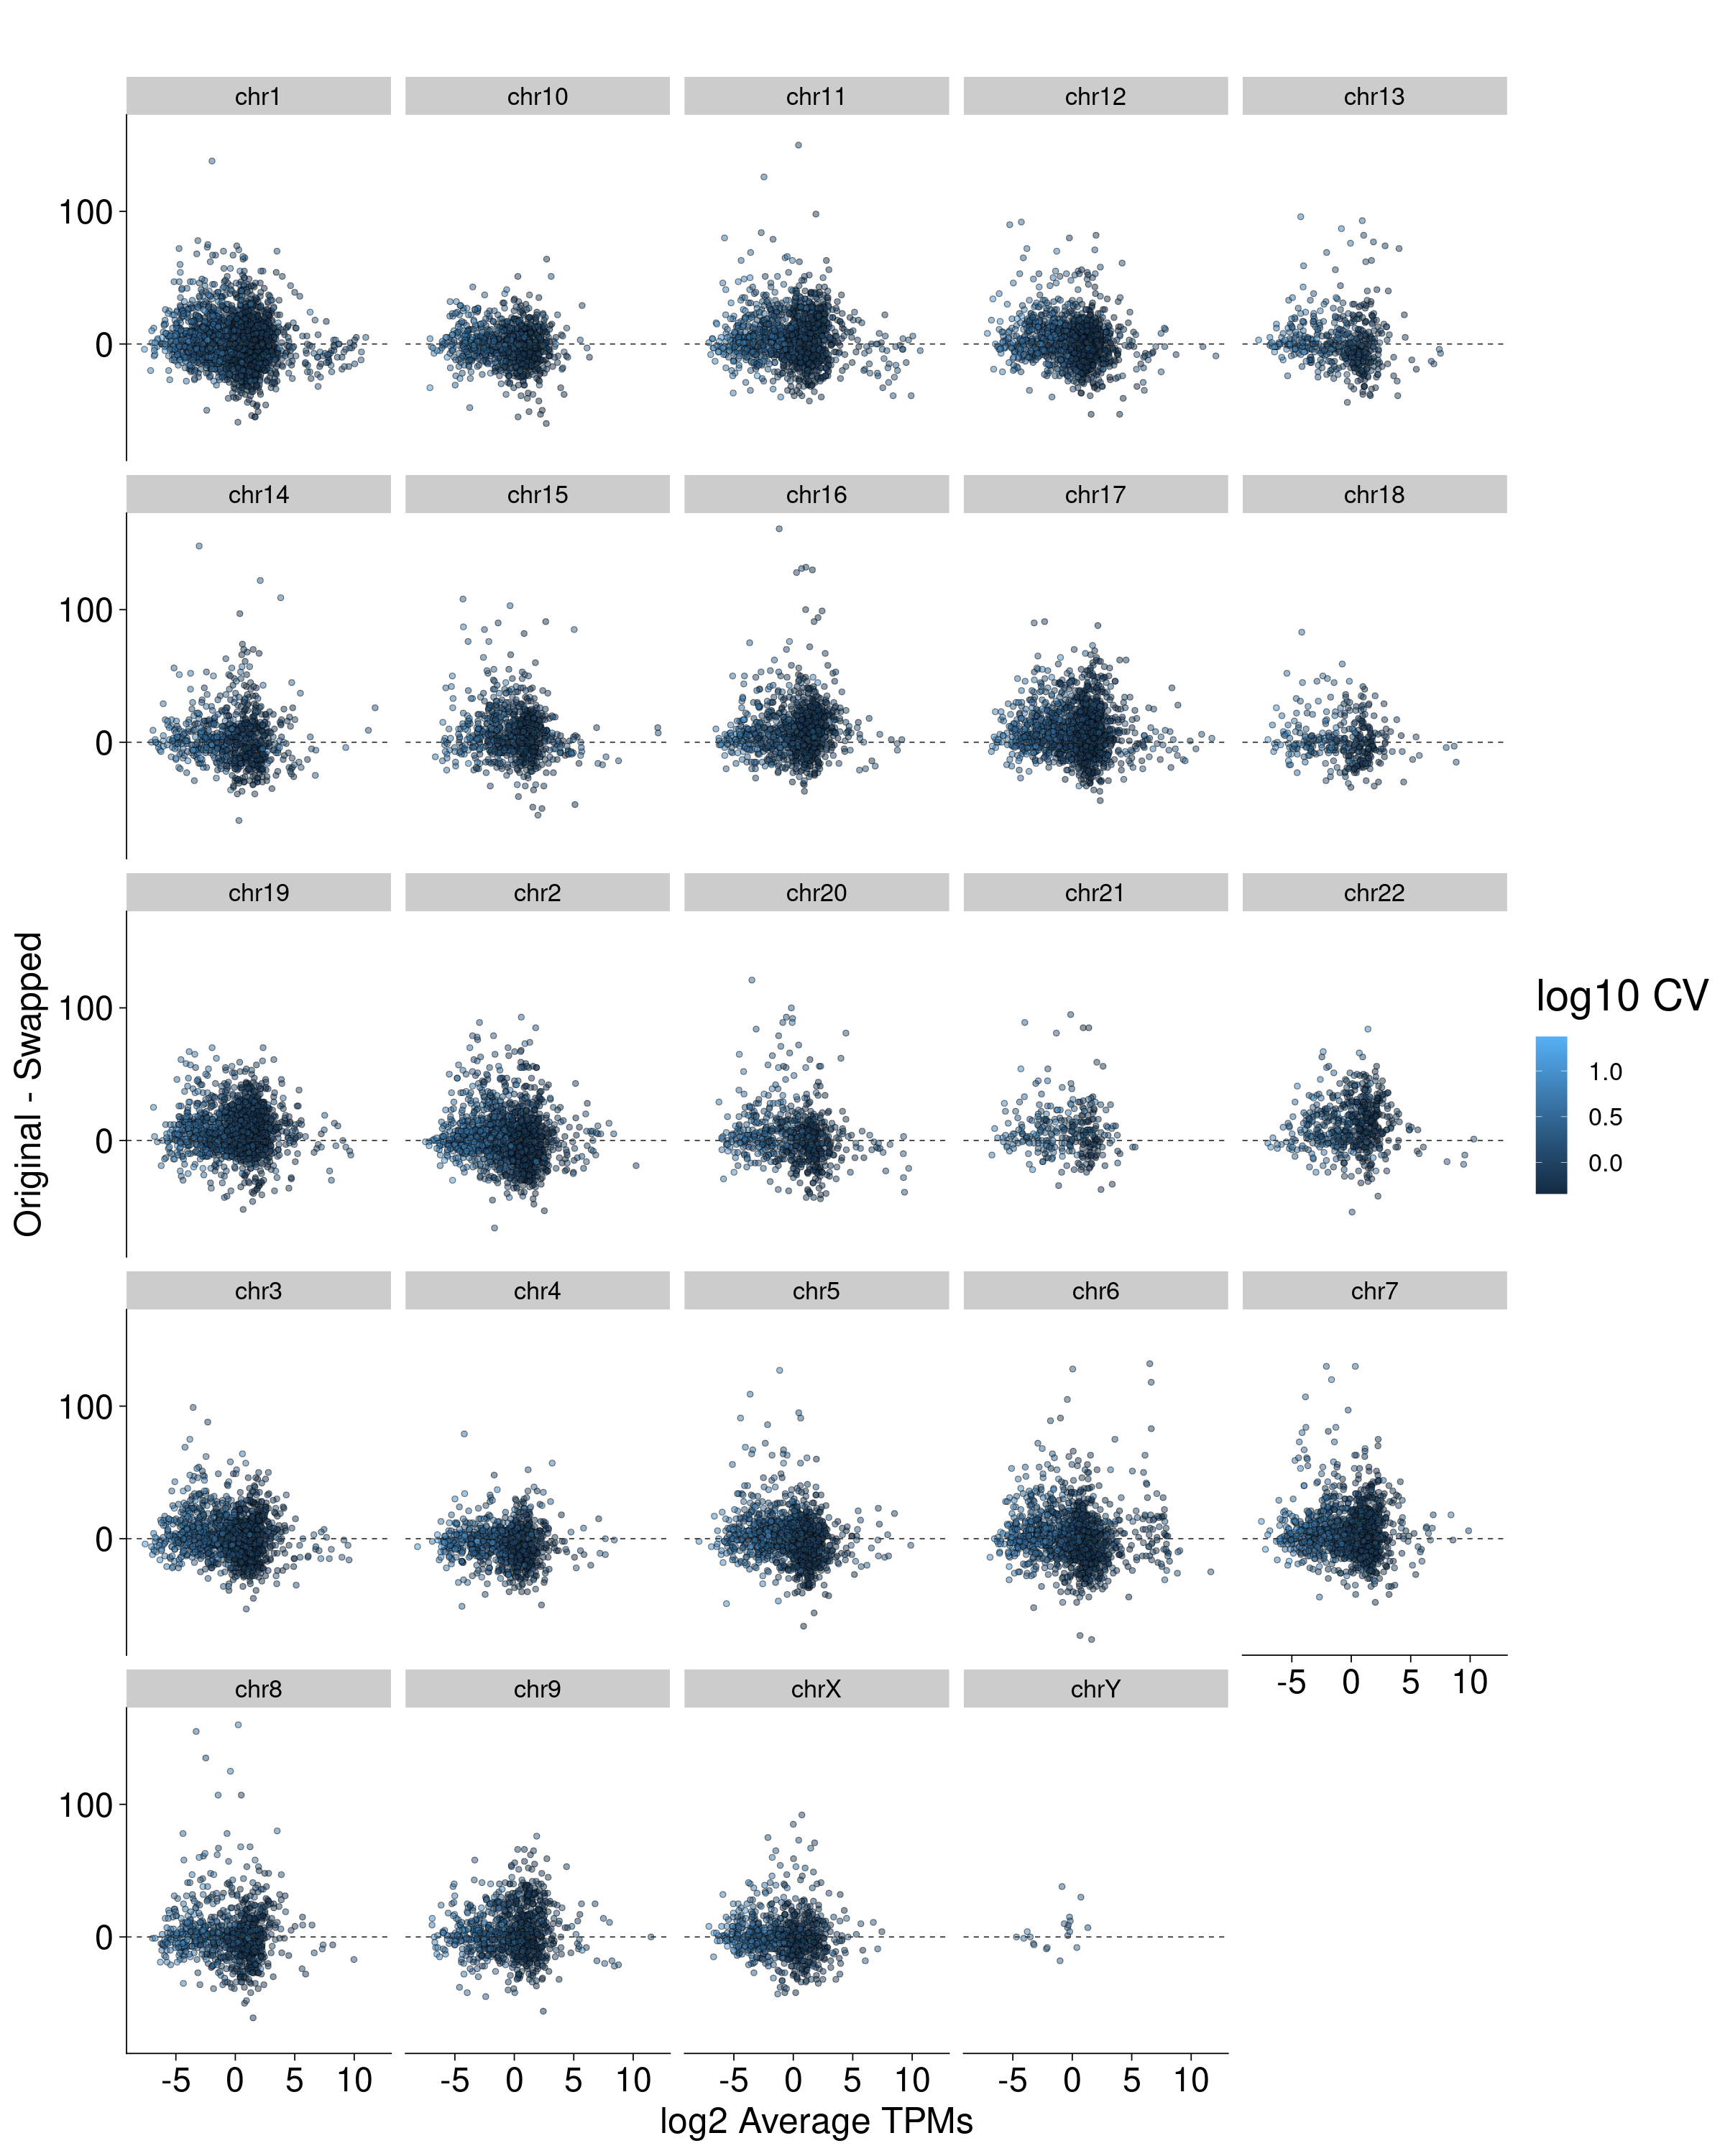

In [24]:
options(repr.plot.width=20, repr.plot.height=25)

diff_num_bidirs_tpms_cv <- ggplot(num_bidirs_per_gene,
                     aes(x=log(mean, 2),
                         y=difference, 
                        fill=log(coefvar, 10))) +
geom_point(shape = 21, size=2, alpha=0.5) + 
geom_hline(yintercept=0, linetype="dashed", color = "gray20") +
facet_wrap(vars(chrom)) +
theme_cowplot(24) + 
ggtitle(" ") +
xlab("log2 Average TPMs") +
ylab("Original - Swapped") +
labs(fill="log10 CV") +
theme(plot.title = element_text(hjust = 0.5),
      title = element_text(size = 36), 
      axis.title = element_text(size = 30), 
      axis.text = element_text(size = 28)) 

diff_num_bidirs_tpms_cv

#### Compared to assignments

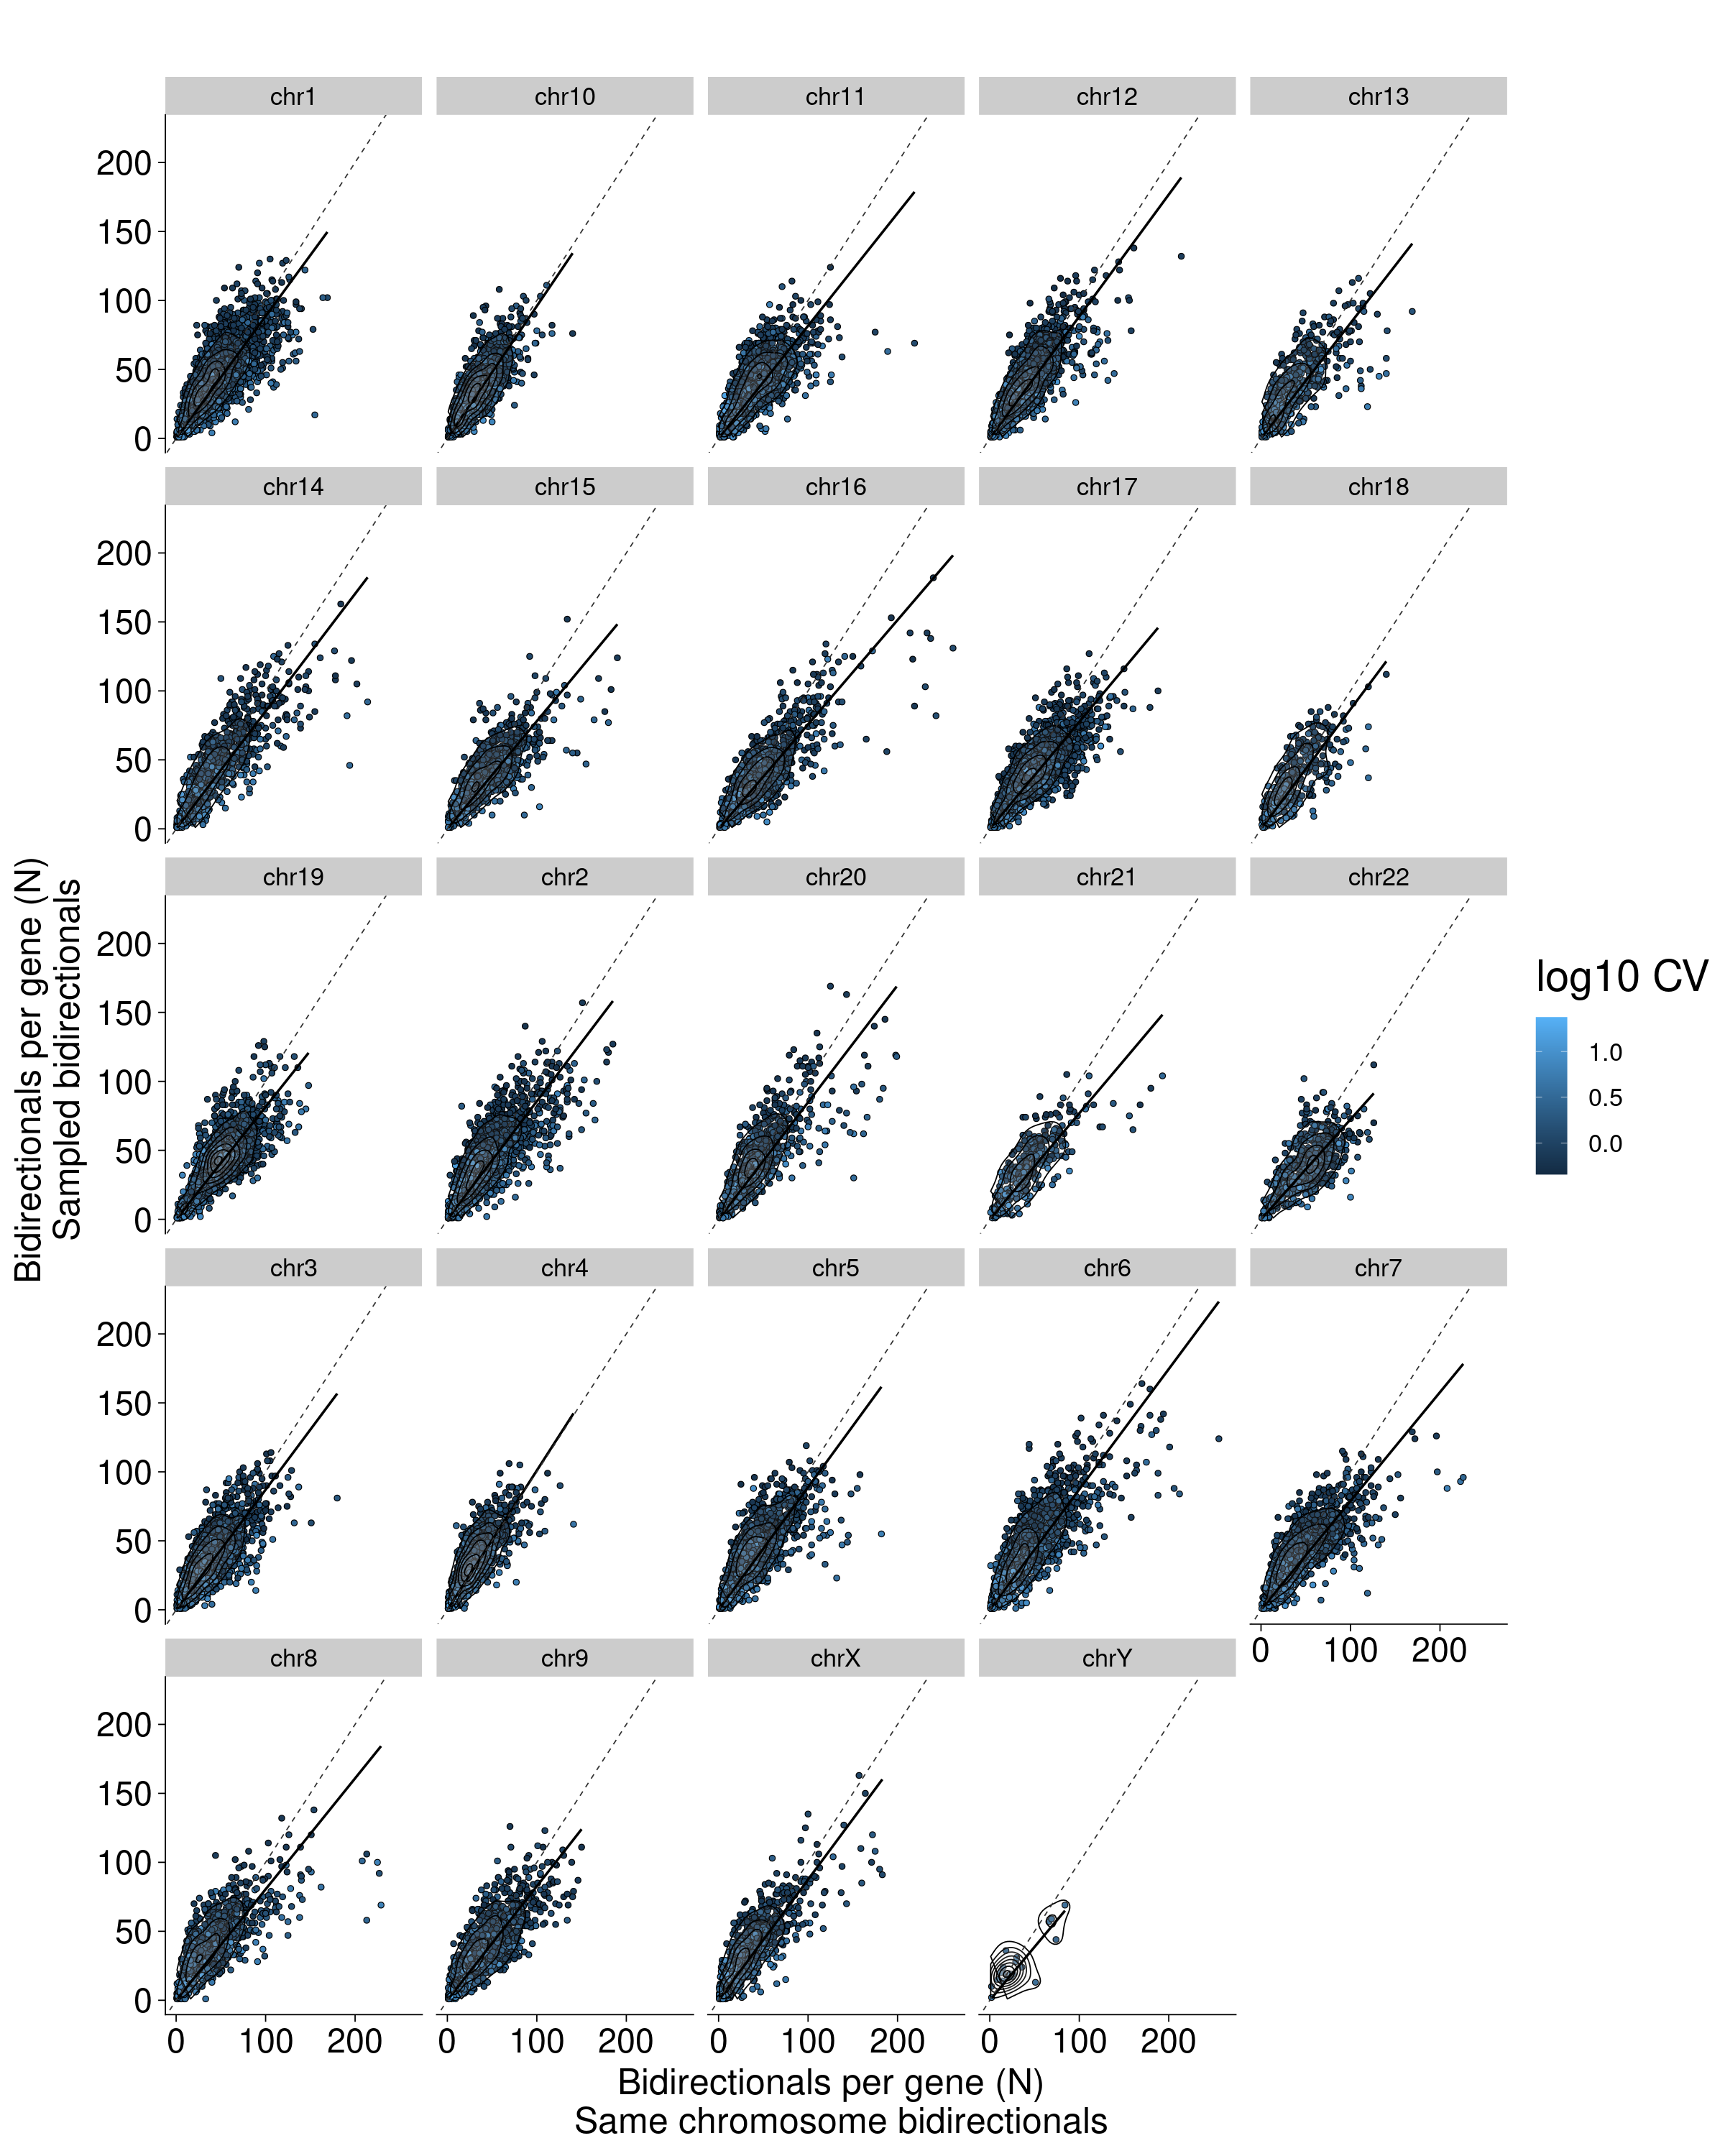

In [25]:
options(repr.plot.width=20, repr.plot.height=25)

num_bidirs_cv <- ggplot(num_bidirs_per_gene,
                     aes(x=og_bidirs,
                         y=swapped_bidirs,
                        fill=log(coefvar, 10))) +
geom_point(shape = 21, size=2) + 
stat_density_2d(aes(fill = ..level..), 
                alpha=0.075,
                geom = "polygon", 
                colour="black", 
                fill='gray90') +
geom_smooth(method = "lm", se = FALSE, color = 'black', formula=y~x+0) +
geom_abline(intercept = 0, slope=1, linetype='dashed', color = 'gray20') +
facet_wrap(vars(chrom)) +
theme_cowplot(24) + 
ggtitle(" ") +
xlab("Bidirectionals per gene (N) \n Same chromosome bidirectionals") +
ylab("Bidirectionals per gene (N) \n Sampled bidirectionals") +
labs(fill="log10 CV") +
theme(plot.title = element_text(hjust = 0.5),
      title = element_text(size = 36), 
      axis.title = element_text(size = 30), 
      axis.text = element_text(size = 28)) 

num_bidirs_cv

### All genes

#### Raw counts

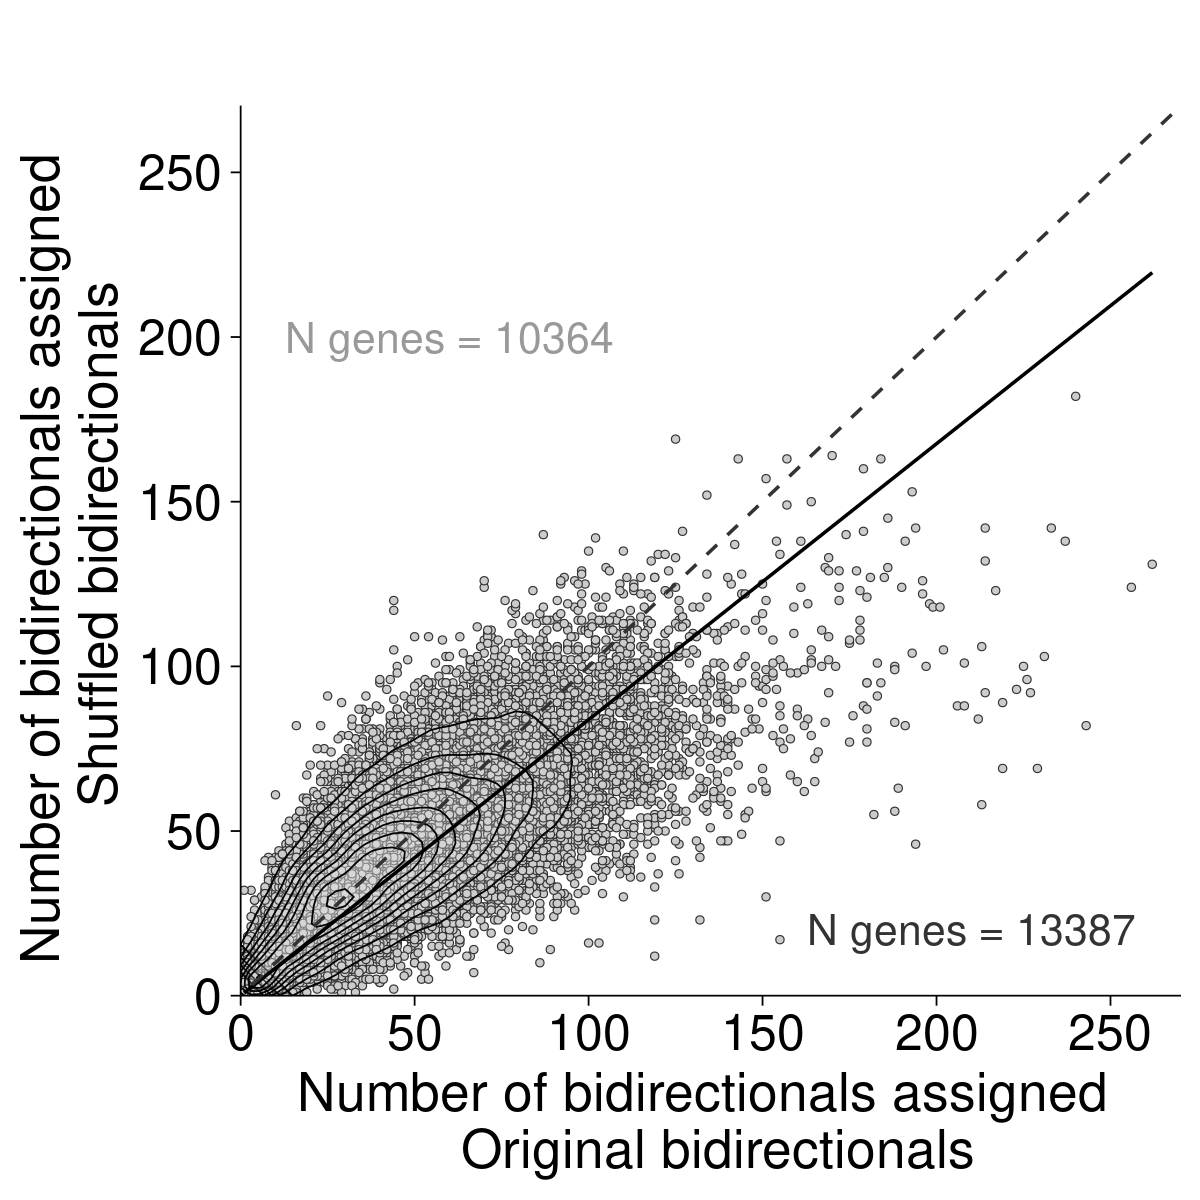

In [26]:
options(repr.plot.width=10, repr.plot.height=10)

num_bidirs_all_genes <- ggplot(num_bidirs_per_gene,
                          aes(x=og_bidirs, y=swapped_bidirs)) +
geom_point(shape = 21, size=2, color='gray20', fill='gray80', alpha=1) + 
stat_density_2d(aes(fill = ..level..), 
                alpha=0.075,
                geom = "polygon", 
                colour="black", 
                fill='gray90') +
geom_smooth(method = "lm", se = FALSE, color = 'black', formula=y~x+0) +
geom_abline(intercept = 0, slope=1, linetype='dashed', color = 'gray20', size=1) +
theme_cowplot(24) + 
ggtitle(" ") +
xlab("Number of bidirectionals assigned \n Original bidirectionals") +
ylab("Number of bidirectionals assigned \n Shuffled bidirectionals") +
annotate("text", x = 210,
         y = 20, size=9, 
         label = paste0("N genes = ",nrow(subset(num_bidirs_per_gene, difference >= 0))),
         color='gray20') +
annotate("text", x = 60,
         y = 200, size=9,
         label = paste0("N genes = ",nrow(subset(num_bidirs_per_gene, difference < 0))),
         color='gray60') +
labs(fill=" ") +
scale_x_continuous(expand = c(0, 0), 
                   limits = c(0,270),
                  breaks=seq(0,270,50)) +
scale_y_continuous(expand = c(0, 0), 
                   limits = c(0,270),
                  breaks=seq(0,270,50)) +
theme(plot.title = element_text(hjust = 0.5),
      title = element_text(size = 36), 
      axis.title = element_text(size = 32), 
      axis.text = element_text(size = 30)) 

num_bidirs_all_genes

In [27]:
ggsave(num_bidirs_all_genes, width = 10, height = 10,
       filename = '/Users/rusi2317/projects/meta_analysis_qc/hg38/paper_figures/num_bidirs_per_gene_original_vs_sampled.pdf',
      bg = "transparent")

ggsave(num_bidirs_all_genes, width = 10, height = 10,
       filename = '/Users/rusi2317/projects/meta_analysis_qc/hg38/paper_figures/num_bidirs_per_gene_original_vs_sampled.png',
      bg = "transparent")

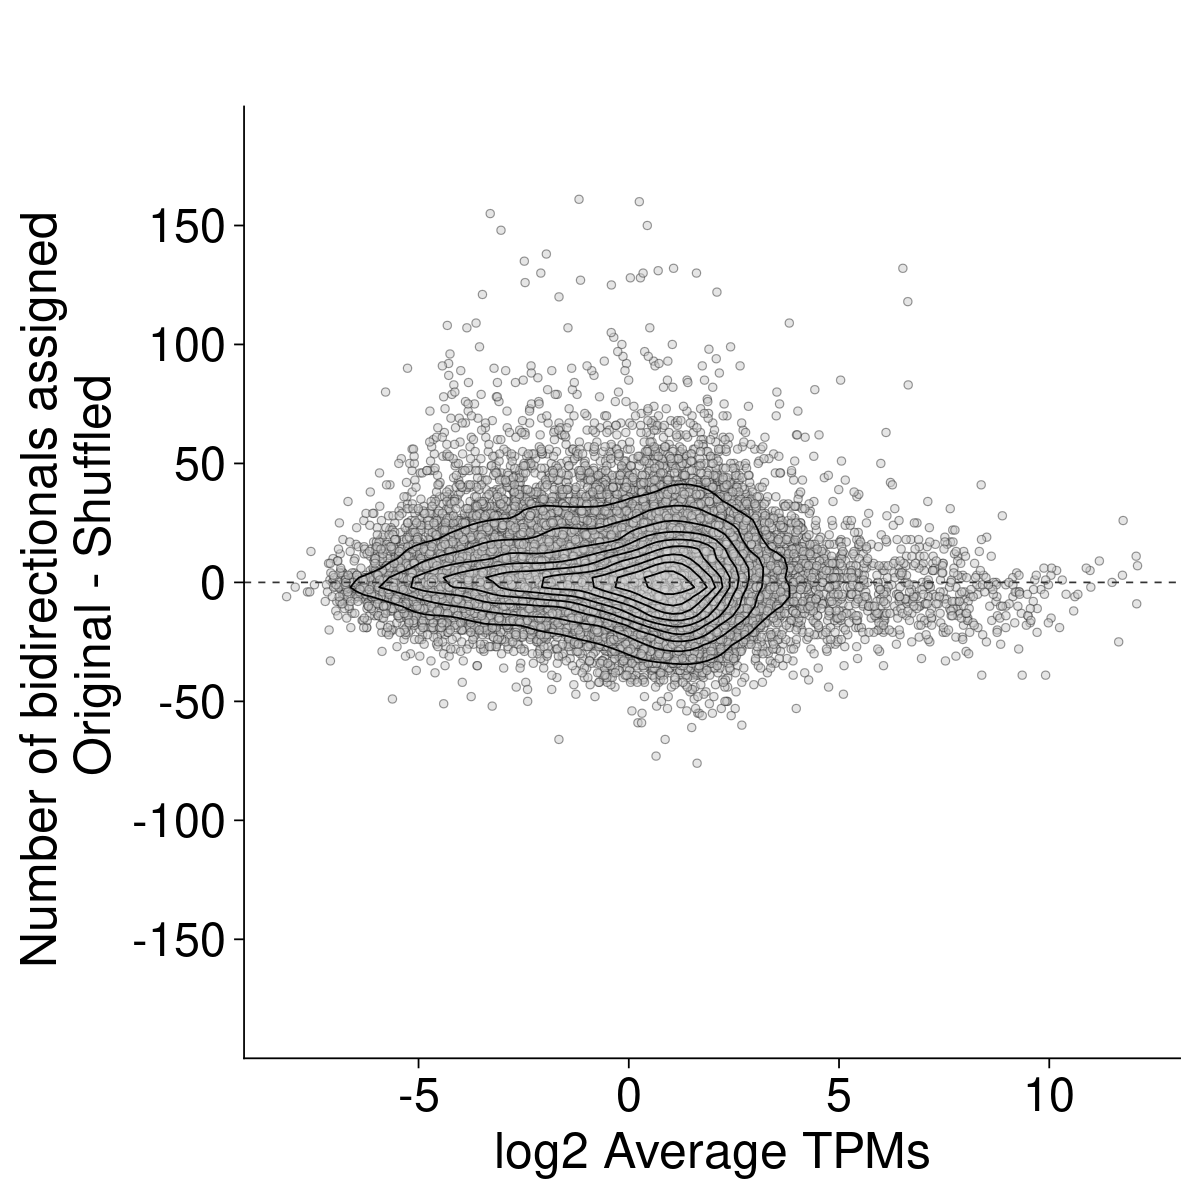

In [28]:
options(repr.plot.width=10, repr.plot.height=10)

num_bidirs_all_genes_diff <- ggplot(num_bidirs_per_gene,
                               aes(x=log(mean, 2),
                                   y=difference)
                          ) +
geom_point(shape = 21, size=2, color='gray20', fill='gray80', alpha=0.5) + 
stat_density_2d(aes(fill = ..level..), 
                alpha=0.075,
                geom = "polygon", 
                colour="black", 
                fill='gray90') +
geom_hline(yintercept=0, linetype="dashed", color = "gray20") +
theme_cowplot(24) + 
ggtitle(" ") +
xlab("log2 Average TPMs") +
ylab("Number of bidirectionals assigned \n Original - Shuffled") +
scale_y_continuous(expand = c(0, 0), 
                   limits = c(-200,200),
                  breaks=seq(-150,150,50)) +
labs(fill=" ") +
theme(plot.title = element_text(hjust = 0.5),
      title = element_text(size = 36), 
      axis.title = element_text(size = 30), 
      axis.text = element_text(size = 28)) 

num_bidirs_all_genes_diff

In [29]:
nrow(subset(num_bidirs_per_gene, difference >= 0))
nrow(subset(num_bidirs_per_gene, difference < 0))

[1] 13387

[1] 10364

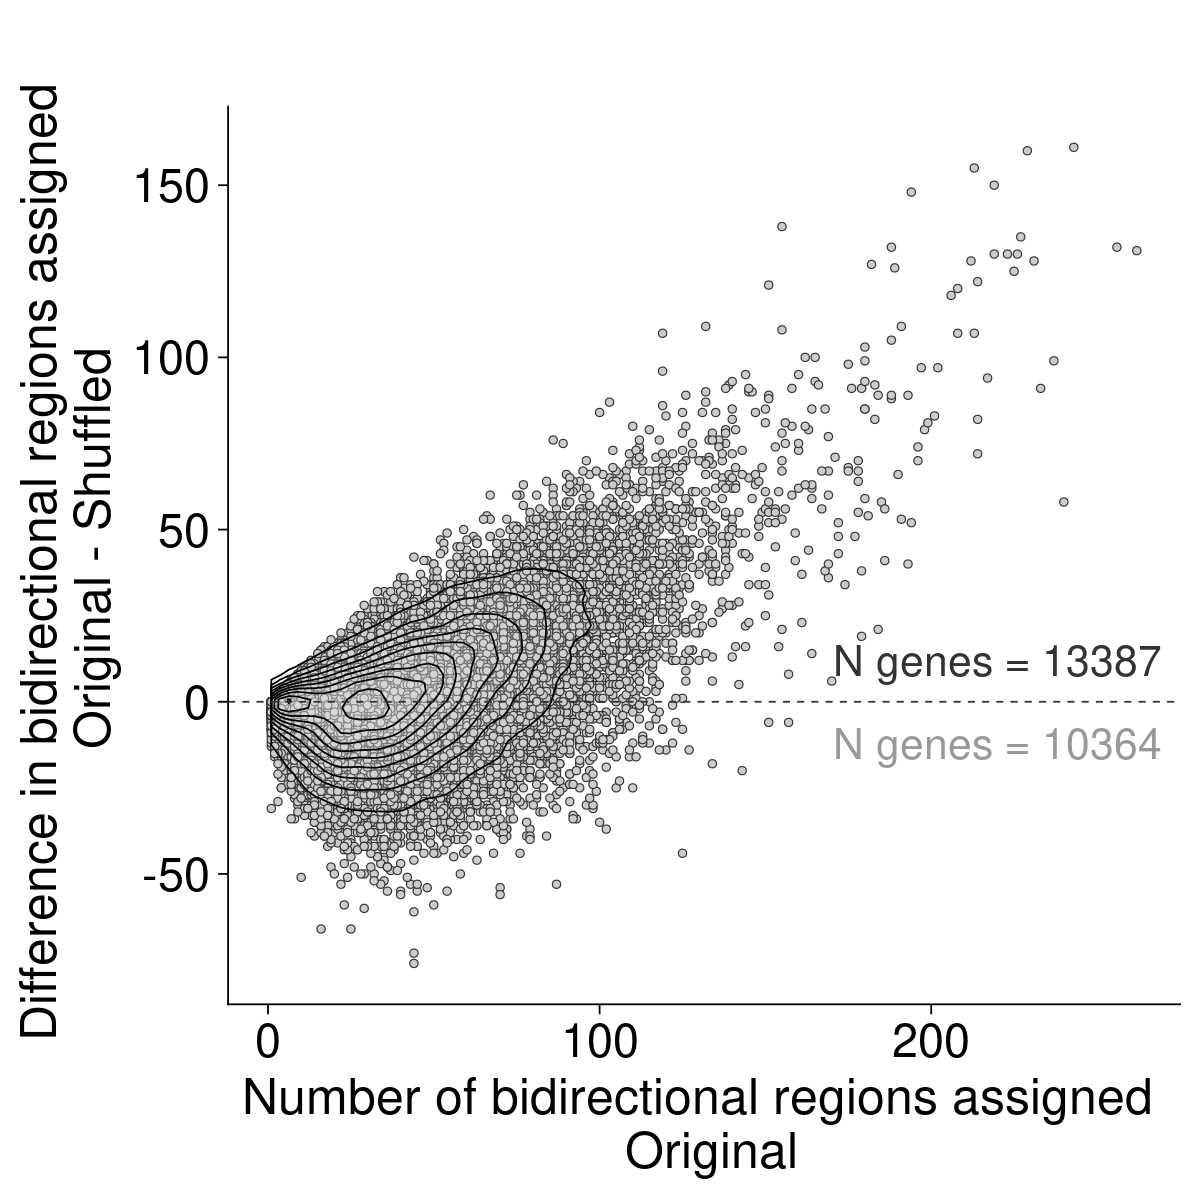

In [35]:
options(repr.plot.width=10, repr.plot.height=10)

num_bidirs_all_genes_diff2 <- ggplot(num_bidirs_per_gene,
                               aes(x=og_bidirs,#log(mean, 2),
                         y=difference)
                          ) +
geom_point(shape = 21, size=2, color='gray20', fill='gray80', alpha=1) + 
stat_density_2d(aes(fill = ..level..), 
                alpha=0.075,
                geom = "polygon", 
                colour="black", 
                fill='gray90') +
geom_hline(yintercept=0, linetype="dashed", color = "gray20") +
theme_cowplot(24) + 
ggtitle(" ") +
xlab("Number of bidirectional regions assigned \n Original") +
ylab("Difference in bidirectional regions assigned \n Original - Shuffled") +
scale_y_continuous(breaks=seq(-150,150,50)) +
annotate("text", x = 220,
         y = 12, size=9, 
         label = paste0("N genes = ",nrow(subset(num_bidirs_per_gene, difference >= 0))),
         color='gray20') +
annotate("text", x = 220,
         y = -12, size=9,
         label = paste0("N genes = ",nrow(subset(num_bidirs_per_gene, difference < 0))),
         color='gray60') +
labs(fill=" ") +
theme(plot.title = element_text(hjust = 0.5),
      title = element_text(size = 36), 
      axis.title = element_text(size = 30), 
      axis.text = element_text(size = 28)) 

num_bidirs_all_genes_diff2

In [36]:
ggsave(num_bidirs_all_genes_diff2, width = 10, height = 10,
       filename = '/Users/rusi2317/projects/meta_analysis_qc/hg38/paper_figures/num_bidirs_per_gene_original_vs_sampled_difference.pdf',
      bg = "transparent")

ggsave(num_bidirs_all_genes_diff2, width = 10, height = 10,
       filename = '/Users/rusi2317/projects/meta_analysis_qc/hg38/paper_figures/num_bidirs_per_gene_original_vs_sampled_difference.png',
      bg = "transparent")


#### Log of counts

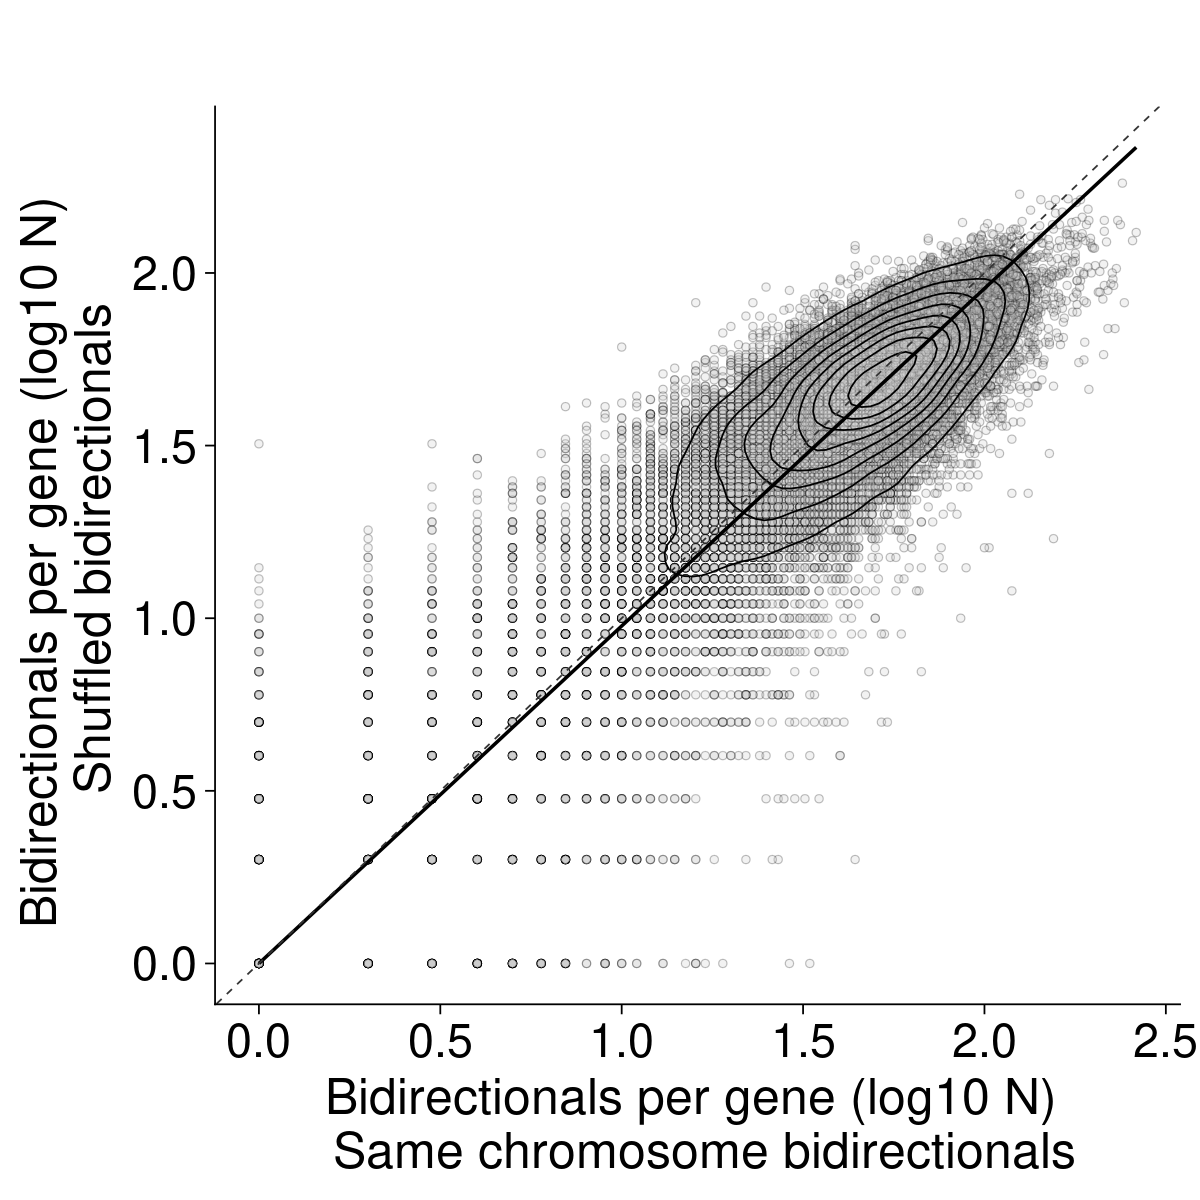

In [33]:
options(repr.plot.width=10, repr.plot.height=10)

num_bidirs_all_genes_log <- ggplot(num_bidirs_per_gene,
                          aes(x=log(og_bidirs, 10), y=log(swapped_bidirs, 10))) +
geom_point(shape = 21, size=2, fill='gray80', alpha=0.25) + 
stat_density_2d(aes(fill = ..level..), 
                alpha=0.075,
                geom = "polygon", 
                colour="black", 
                fill='gray90') +
geom_smooth(method = "lm", se = FALSE, color = 'black', formula=y~x+0) +
geom_abline(intercept = 0, slope=1, linetype='dashed', color = 'gray20') +
theme_cowplot(24) + 
ggtitle(" ") +
xlab("Bidirectionals per gene (log10 N) \n Same chromosome bidirectionals") +
ylab("Bidirectionals per gene (log10 N) \n Shuffled bidirectionals") +
labs(fill=" ") +
theme(plot.title = element_text(hjust = 0.5),
      title = element_text(size = 36), 
      axis.title = element_text(size = 30), 
      axis.text = element_text(size = 28)) 

num_bidirs_all_genes_log

#### IQR

In [34]:
sampled_quantile_new <- quantile(num_bidirs_per_gene$og_bidirs,
                       probs = c(0, 0.1, 0.2, 0.3, 0.4,
                                 0.5, 0.6, 0.7, 0.8, 0.9, 1)) 
sampled_quantile_new

0%  10%  20%  30%  40%  50%  60%  70%  80%  90% 100% 
   1   13   22   29   35   42   49   57   67   82  262

In [35]:
num_bidirs_per_gene_Q2Q3 <- subset(num_bidirs_per_gene,
                                              og_bidirs > 13 & 
                                              og_bidirs < 82   
                                  )
nrow(num_bidirs_per_gene_Q2Q3)

[1] 18793

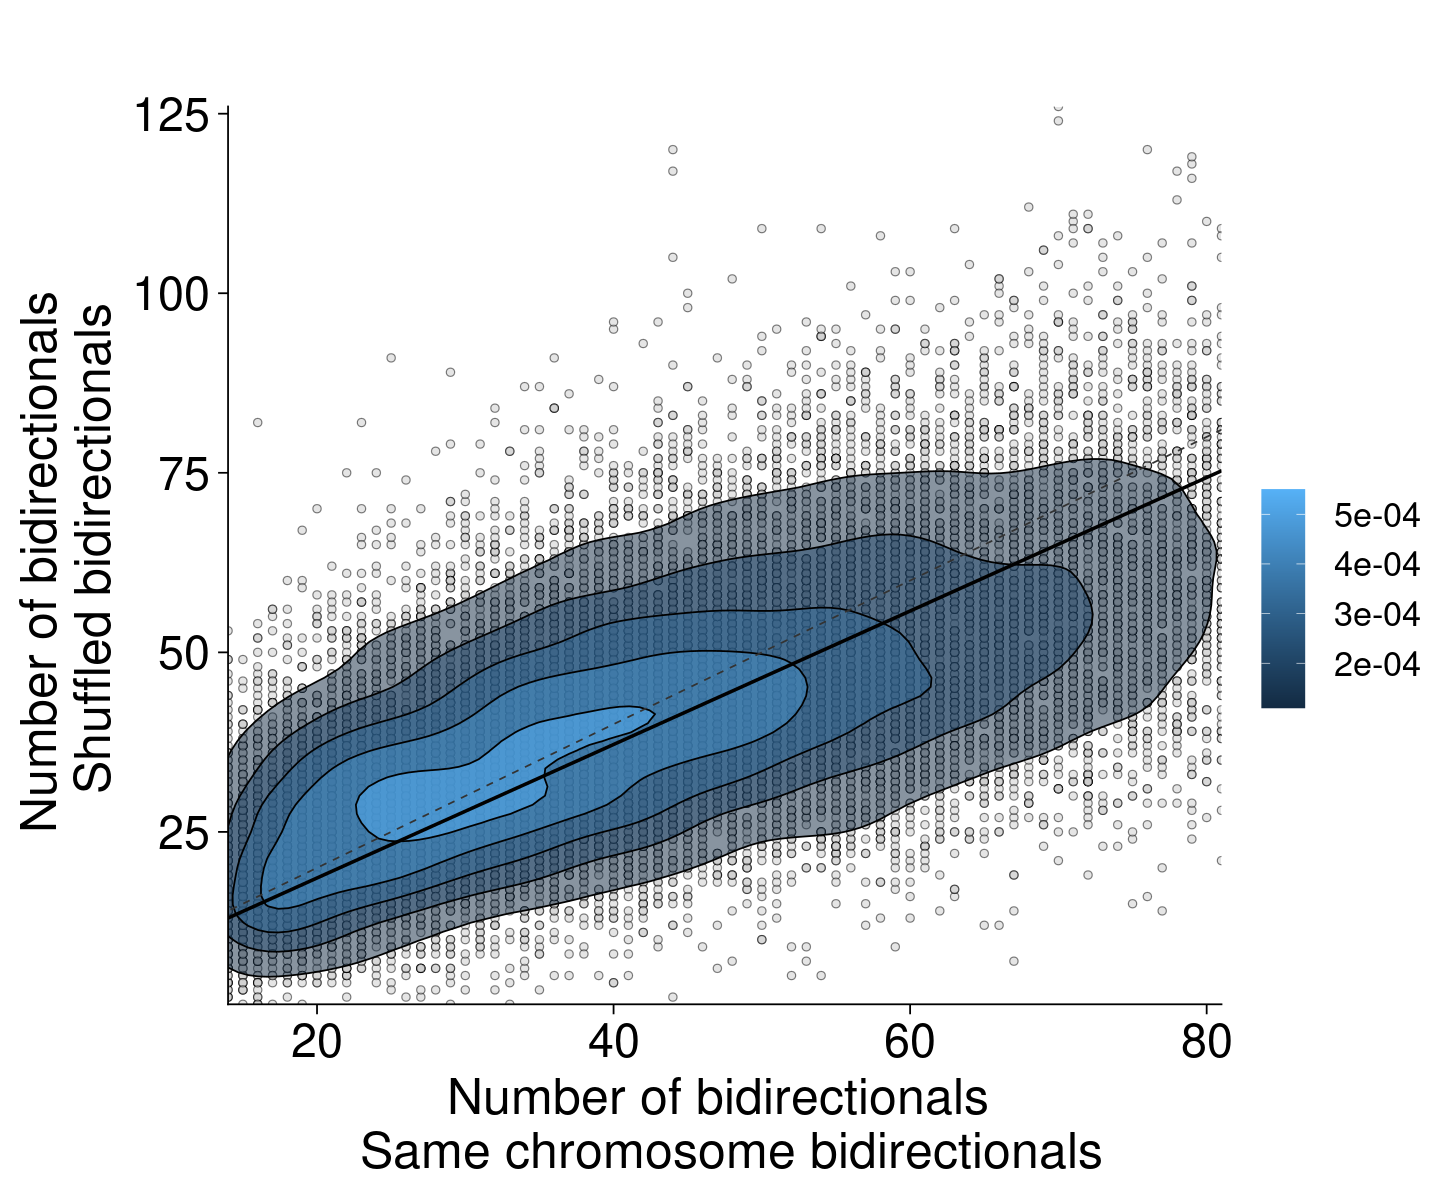

In [36]:
options(repr.plot.width=12, repr.plot.height=10)

num_bidirs_swapped_q2q3 <- ggplot(num_bidirs_per_gene_Q2Q3,
                          aes(x=og_bidirs,
                              y=swapped_bidirs)) +
geom_point(shape = 21, size=2, alpha=0.5, fill='gray80') + 
stat_density_2d(geom = "polygon", contour = TRUE,
                  aes(fill = after_stat(level)), 
                colour = "black",
                  bins = 6, alpha=0.5)+
geom_smooth(method = "lm", se = FALSE, color = 'black', formula=y~x+0) +
geom_abline(intercept = 0, slope=1, linetype='dashed', color = 'gray20') +
scale_x_continuous(expand = c(0, 0)) +
scale_y_continuous(expand = c(0, 0)) +
theme_cowplot(24) + 
ggtitle(" ") +
xlab("Number of bidirectionals \n Same chromosome bidirectionals") +
ylab("Number of bidirectionals \n Shuffled bidirectionals") +
labs(fill=" ") +
theme(plot.title = element_text(hjust = 0.5),
      title = element_text(size = 36), 
      axis.title = element_text(size = 30), 
      axis.text = element_text(size = 28)) 

num_bidirs_swapped_q2q3

In [37]:
ggsave(num_bidirs_swapped_q2q3, width = 12, height = 10,
       filename = '/Users/rusi2317/projects/meta_analysis_qc/hg38/paper_figures/num_bidirs_per_gene_original_vs_sampled_mid80perc.pdf',
      bg = "transparent")

ggsave(num_bidirs_swapped_q2q3, width = 12, height = 10,
       filename = '/Users/rusi2317/projects/meta_analysis_qc/hg38/paper_figures/num_bidirs_per_gene_original_vs_sampled_mid80perc.png',
      bg = "transparent")


# Remove genes above the dotted line

## Get all genes with high FP

In [39]:
#Create equation to remove gene below the line
#num_bidirs_per_gene %>% mutate(ye=0+1*og_bidirs,lab=ifelse(swapped_bidirs<ye,swapped_bidirs,NA)) -> num_bidirs_per_gene_line

above_line <- subset(num_bidirs_per_gene, difference <=0)
nrow(above_line)

[1] 11124

## Get example gene

In [50]:
subset(num_bidirs_per_gene, gene=='HCG18:NR_024052.2')

gene              og_bidirs swapped_bidirs difference chrom start   
19100 HCG18:NR_024052.2 96        88             8          chr6  30287396
      stop     score strand length ⋯ variance sum      mean     median  
19100 30326406 .     -      39011  ⋯ 17.5459  3833.595 5.104653 4.373905
      coefvar   max     min         num_transcribed percent_transcribed
19100 0.8205813 31.4766 0.005898676 751             100                
      transcript_type
19100 genes

# Gasperini pairs

In [40]:
gasperini_bidirectionals <- data.table::fread('/Users/rusi2317/projects/meta_analysis_qc/hg38/processed_data/gasperini_nascent_pairs/gasperini_bidirCalls_overlap.bed')
nrow(gasperini_bidirectionals)
head(gasperini_bidirectionals, 3)


[1] 644

V1   V2       V3       V4   V5    V6   V7       V8       V9   V10 V11
1 chr1  1134850  1135934 NADK FALSE chr1  1134922  1135218 tfit  1  .  
2 chr1  1134850  1135934 NADK FALSE chr1  1135575  1136169 dreg 35  .  
3 chr1 12038249 12039371 MIIP FALSE chr1 12038675 12039055 dreg  5  .

In [41]:
gasperini_bidirectionals$bidir_id <- paste0(gasperini_bidirectionals$V6,':',
                                           gasperini_bidirectionals$V7,'-',
                                           gasperini_bidirectionals$V8)
head(gasperini_bidirectionals, 3)

V1   V2       V3       V4   V5    V6   V7       V8       V9   V10 V11
1 chr1  1134850  1135934 NADK FALSE chr1  1134922  1135218 tfit  1  .  
2 chr1  1134850  1135934 NADK FALSE chr1  1135575  1136169 dreg 35  .  
3 chr1 12038249 12039371 MIIP FALSE chr1 12038675 12039055 dreg  5  .  
  bidir_id              
1 chr1:1134922-1135218  
2 chr1:1135575-1136169  
3 chr1:12038675-12039055

In [42]:
gasperini_bidirectionals_transcribed <- gasperini_bidirectionals[gasperini_bidirectionals$bidir_id %in%
                                                                 sig_pairs_path_DT_filt$transcript_2,]
nrow(gasperini_bidirectionals_transcribed)
head(gasperini_bidirectionals_transcribed, 3)

[1] 402

V1   V2       V3       V4   V5    V6   V7       V8       V9   V10 V11
1 chr1  1134850  1135934 NADK FALSE chr1  1134922  1135218 tfit  1  .  
2 chr1  1134850  1135934 NADK FALSE chr1  1135575  1136169 dreg 35  .  
3 chr1 12038249 12039371 MIIP FALSE chr1 12038675 12039055 dreg  5  .  
  bidir_id              
1 chr1:1134922-1135218  
2 chr1:1135575-1136169  
3 chr1:12038675-12039055

In [43]:
gasperini_bidirectionals_unique <- unique(gasperini_bidirectionals_transcribed[,c('V1','V2','V3','V4')])
nrow(gasperini_bidirectionals_unique)
head(gasperini_bidirectionals_unique, 3)

[1] 379

V1   V2       V3       V4  
1 chr1  1134850  1135934 NADK
2 chr1 12038249 12039371 MIIP
3 chr1 25933356 25934013 CD52

In [44]:
gasperini_bidirectionals_unique_transcribed_nascent <- gasperini_bidirectionals_unique[gasperini_bidirectionals_unique$V4 %in%
                                                                     sig_pairs_path_DT_filt$gene_id,]
nrow(gasperini_bidirectionals_unique_transcribed_nascent)
head(gasperini_bidirectionals_unique_transcribed_nascent, 3)

[1] 357

V1   V2       V3       V4  
1 chr1  1134850  1135934 NADK
2 chr1 12038249 12039371 MIIP
3 chr1 25933356 25934013 CD52

## Get overlaps with pairs

In [45]:
gasperini_path <- "/Users/rusi2317/projects/meta_analysis_qc/hg38/processed_data/gasperini_nascent_pairs"

##get paths for the counts tables
gasperini_path_files <- list.files(path=gasperini_path, 
                              pattern="gasperini_tissue_bidir*",#"*.bed", 
                                   full.names=TRUE)

##load files
gasperini_DT_list <- lapply(gasperini_path_files, 
                                   data.table::fread)

gasperini_path_files 

[1] "/Users/rusi2317/projects/meta_analysis_qc/hg38/processed_data/gasperini_nascent_pairs/gasperini_tissue_bidir_intersect_0.6.bed"
[2] "/Users/rusi2317/projects/meta_analysis_qc/hg38/processed_data/gasperini_nascent_pairs/gasperini_tissue_bidir_intersect_0.7.bed"
[3] "/Users/rusi2317/projects/meta_analysis_qc/hg38/processed_data/gasperini_nascent_pairs/gasperini_tissue_bidir_intersect_0.8.bed"
[4] "/Users/rusi2317/projects/meta_analysis_qc/hg38/processed_data/gasperini_nascent_pairs/gasperini_tissue_bidir_intersect_0.9.bed"

In [46]:
gasperini_overlap_list <- lapply(gasperini_DT_list, map_overlaps, nascent_pairs=sig_pairs_path_DT_filt)

In [47]:
lapply(gasperini_overlap_list, nrow)

[[1]]
[1] 114

[[2]]
[1] 88

[[3]]
[1] 55

[[4]]
[1] 12

In [48]:
gasperini_overlap_0.6 <- gasperini_overlap_list[[1]]
paste0("More False pairs : N = ", 
       nrow(gasperini_overlap_0.6[gasperini_overlap_0.6$transcript_1 %in%
                                  above_line$gene,]))

paste0("More True pairs : N = ", 
       nrow(gasperini_overlap_0.6[!gasperini_overlap_0.6$transcript_1 %in%
                                  above_line$gene,])) 

[1] "More False pairs : N = 31"

[1] "More True pairs : N = 83"

# Session Information

In [49]:
print(sessionInfo())

R version 3.6.0 (2019-04-26)
Platform: x86_64-redhat-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /usr/lib64/R/lib/libRblas.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] dplyr_1.0.10      cowplot_1.1.1     ggplot2_3.3.6     data.table_1.14.2

loaded via a namespace (and not attached):
 [1] pillar_1.8.1      compiler_3.6.0    R.methodsS3_1.8.2 R.utils_2.12.0   
 [5] base64enc_0.1-3   tools_3.6.0       digest_0.6.29     uuid_1.1-0       
 [9] lattice_0.20-38   nlme_3.1-139      jsonlite_1.8.0    ev